In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as colors
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [9]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', family='serif',size=20)
plt.rc('axes', linewidth=3.0)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('legend', fontsize=20)

# setting xtick parameters:

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=10,pad=8)

plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=10)

# Functions

In [10]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    return Pratios

def compute_model(theta):
    """
    Computes the model observation periods given a set of parameters at the observation indices
    """

    sim = makesim(theta)
    
    period_ratios = run(sim)

    return period_ratios[obs_idx]

def lnlike(theta):
    
    """
    Determines the gaussian log likelihood.
    obs: period ratio observations
    theta: parameters
    obs_err: errors in the shape of (obs,sample_size) for K2 and TESS
    """
    e_forced, e_free, mu, deltaT = theta
    
    model = compute_model(theta)
    #print(model)
    argument = (obs - model)**2 / obs_err**2

    loglike = 0.5*np.sum(argument)
    return loglike

In [11]:
def corner_plot(res_arr, preds_arr, sigma_limits, labels, weighted=True,pl_b=False,ecc_b=False, pl_e=False, ecc_e=False):
     
    if pl_b:
        ndim = np.shape(res_arr)[1]
    else:
        ndim = 3
    
    plt.rcParams['figure.facecolor'] = 'white'
    fig = corner.corner(
        np.array(res_arr), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
        hist_kwargs={'color':'k','density':True,'zorder': 1},       
        plot_datapoints=False,
        weights=preds_arr
    )

    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i,yi in enumerate(range(ndim)):
        
        for xi in range(yi):
            ax = axes[yi, xi]
             
            ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], np.array(res_arr)[:,yi][preds_arr!=0.0],
                       color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=0.5,zorder=1)
            ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
                       color="r", 
                       alpha=0.3, s=0.5,zorder=0)

    
    if weighted==True:
        for i in range(ndim):
            ax = axes[i, i]
            ax.hist(np.array(res_arr)[:,i], color='k', histtype='step',density=True, linestyle=('dashed'),
                    zorder=0)
            ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(sigma_limits[i]), fontsize=15)
            ax.axvline(x=sigma_limits[i], ls='--',color='k')
            
            if pl_b:
                if i == 3:
                    ax.axvline(x=m_b_2sigma_rv, ls='--',color='g')
                    #ax.axvspan(-6.5, m_b_2sigma_rv, alpha=0.05, color='g')

                    ax.axvline(x=sigma_limits[3], ls='--',color='k')
                    #ax.axvspan(-6.5, sigma_limits[3], alpha=0.05, color='k')

                if ecc_b:
                    if i == 4:
                        ax.axvline(x=e_b_2sigma_rv, ls='--',color='g')
                        #ax.axvspan(0.0, e_b_2sigma_rv, alpha=0.05, color='g')

                        ax.axvline(x=sigma_limits[4], ls='--',color='k')
                        #ax.axvspan(0.0, sigma_limits[4], alpha=0.05, color='k')
    
    plt.show()

In [12]:
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

In [13]:
def sampler(nsamples, post_array, bmass_lims=[8.964e-6, 3*(9.54e-4)], rv_params=True):
    
    sim_list = []
    indices = []
    
    pbar = tqdm(total=nsamples)
    while len(sim_list) < nsamples:
        
        # rv priors
        if rv_params:

            #m_b = float(stats.norm.rvs(loc=0.64, scale=0.19))*1e-3
            mb = float(stats.truncnorm.rvs(a=(0 - 0.69)/0.19, b = np.inf, loc=0.69, scale=0.19, size=1))*9.54e-4

            eb = float(stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=1))

        else:
        # uninformative priors
            mb = float(stats.loguniform.rvs(float(bmass_lims[0]), float(bmass_lims[1]), size=1))

            eb = float(np.random.uniform(0, 0.3, size=1))  
            
            if mb < 0 or eb < 0.0:
                    continue

        # selecting random sample from the rejeciton posteriors:
        ind = int(np.random.randint(0, len(post_array), size=1))
        sim = makesim(post_array[ind])
        
        pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
        theta_b = float(np.random.uniform(0, 2*np.pi, size=1))
        sim.add(m=mb, P=sim.particles[2].P*1.946, e=eb, pomega=pomega_b, theta=theta_b)
        
        sim.move_to_com()

        sim_list.append(sim)
        indices.append(ind) # important to keep for the weighted results

        pbar.update()
    pbar.close()
    
    return sim_list, indices
            
def spock_pred(simlist):
    model = FeatureClassifier()
    return model.predict_stable(simlist)

def weighted_results(sims, indices, sigma, post_array):
    pred = spock_pred(sims)
    
    # planet b posteriors
    mb = [np.log10(s.particles[-1].m) for s in sims]
    eb = [s.particles[-1].e for s in sims]
          
    s = np.array(post_array)[indices]

    s_results = []
    for i,r in enumerate(s):
        p = list(r)
        p.append(mb[i])
        p.append(eb[i])
        s_results.append(p)
        
    for j in s_results:
        del j[3]
    # calculating upper bounds using the SPOCK probabilities as weights
    sigma_list = [float(DescrStatsW(data=np.array(s_results)[:,i], 
                         weights=pred).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(s_results)[1])]
    
    return s_results, pred, sigma_list

In [14]:
def sres_2_post(post_array, s_res, indices):
    """ 
    This function exists to fix past mistakes, so ignore if you can.
    """ 
    
    deltaTs = [np.array(post_array)[indices][i][-1] for i in tqdm(range(len(np.array(post_array)[indices])))]
    
    post_res = []
    
    for i,param in enumerate(s_res):
        deltaT = deltaTs[i]
        res_params = param[:3]
        res_params.append(deltaT)

        post_res.append(res_params)
        
    mb_array = np.array([s_res[i][-2] for i in range(len(s_res))])
    eb_array = np.array([s_res[i][-1] for i in range(len(s_res))])
        
    post = np.c_[post_res,mb_array,eb_array]
        
    return post

# Reading the rejection posteriors

In [15]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_60mil/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
mus = [like_output[i][-1] for i in range(len(like_output))]
deltaTs = [like_output[i][2] for i in range(len(like_output))]

like_output = []

for p,mu,T in zip(params,mus,deltaTs):
    r = list(p)
    r.append(mu)
    r.append(T)
    
    like_output.append(r)

61700000
9693


## Sampling RV parameters for planet b

In [16]:
Nsamps = int(1e5)
np.random.seed(42)
simlist_rv, indices_rv = sampler(Nsamps, like_output)

100%|██████████| 100000/100000 [13:33<00:00, 122.97it/s]


In [17]:
s_results_rv, preds_rv, sigma_list_rv = weighted_results(simlist_rv, 
                                                            indices_rv, 0.997, like_output)

In [18]:
rv_post = sres_2_post(like_output, s_results_rv, indices_rv)

100%|██████████| 100000/100000 [37:28<00:00, 44.47it/s]


In [19]:
np.save('stability_posteriors/100k_rv_priors_100mil_lnlike_randomtheta.npy', rv_post)

In [13]:
#np.random.seed(42)
#simlist_logu, indices_logu = sampler(Nsamps, like_output, rv_params=False)


  4%|▎         | 3734/100000 [00:29<12:44, 125.94it/s]


  7%|▋         | 7482/100000 [00:59<12:52, 119.72it/s]


 11%|█         | 11199/100000 [01:29<12:02, 122.95it/s]


 15%|█▍        | 14864/100000 [01:58<11:03, 128.35it/s]


 19%|█▊        | 18544/100000 [02:27<10:44, 126.36it/s]


 22%|██▏       | 22221/100000 [02:57<10:24, 124.45it/s]


 26%|██▌       | 25896/100000 [03:26<09:38, 128.04it/s]


 30%|██▉       | 29585/100000 [03:55<09:45, 120.19it/s]


 33%|███▎      | 33242/100000 [04:24<08:47, 126.57it/s]


 37%|███▋      | 36916/100000 [04:54<08:26, 124.64it/s]


 41%|████      | 40565/100000 [05:23<07:39, 129.37it/s]


 44%|████▍     | 44252/100000 [05:52<07:12, 128.77it/s]


 48%|████▊     | 47932/100000 [06:21<06:49, 127.29it/s]


 52%|█████▏    | 51583/100000 [06:51<06:33, 122.94it/s]


 55%|█████▌    | 55241/100000 [07:20<05:54, 126.12it/s]


 59%|█████▉    | 58916/100000 [07:49<05:31, 123.86it/s]


 63%|██████▎   | 62577/100000 [08:18<05:03, 123.44it/s]


 66%|██████▌   | 66249/100000 [08:47<04:39, 120.89it/s]


 70%|██████▉   | 69885/100000 [09:17<03:53, 128.79it/s]


 74%|███████▎  | 73523/100000 [09:46<03:39, 120.75it/s]


 77%|███████▋  | 77159/100000 [10:16<03:00, 126.63it/s]


 81%|████████  | 80820/100000 [10:45<02:33, 125.16it/s]


 84%|████████▍ | 84465/100000 [11:14<02:08, 120.66it/s]


 88%|████████▊ | 88133/100000 [11:43<01:34, 125.94it/s]


 92%|█████████▏| 91810/100000 [12:13<01:04, 126.58it/s]


 95%|█████████▌| 95456/100000 [12:42<00:35, 129.50it/s]


 99%|█████████▉| 99124/100000 [13:11<00:07, 124.14it/s]


100%|██████████| 100000/100000 [13:18<00:00, 125.22it/s][A


In [14]:
#s_results_logu, preds_logu, sigma_list_logu = weighted_results(simlist_logu,
#                                                            indices_logu, 0.997, like_output)

In [15]:
#logu_post = sres_2_post(like_output, s_results_logu, indices_logu)


  1%|          | 1160/100000 [00:32<45:28, 36.22it/s]


  2%|▏         | 2304/100000 [01:03<47:49, 34.05it/s]


  3%|▎         | 3448/100000 [01:34<43:55, 36.64it/s]


  5%|▍         | 4592/100000 [02:06<43:30, 36.54it/s]


  6%|▌         | 5736/100000 [02:37<43:07, 36.43it/s]


  7%|▋         | 6880/100000 [03:09<42:21, 36.64it/s]


  8%|▊         | 8024/100000 [03:40<41:50, 36.63it/s]


  9%|▉         | 9168/100000 [04:12<41:41, 36.31it/s]


 10%|█         | 10308/100000 [04:43<41:02, 36.43it/s]


 11%|█▏        | 11436/100000 [05:14<40:15, 36.66it/s]


 13%|█▎        | 12564/100000 [05:45<40:15, 36.19it/s]


 14%|█▎        | 13692/100000 [06:16<39:14, 36.66it/s]


 15%|█▍        | 14820/100000 [06:47<38:59, 36.40it/s]


 16%|█▌        | 15948/100000 [07:18<38:27, 36.43it/s]


 17%|█▋        | 17076/100000 [07:49<37:45, 36.60it/s]


 18%|█▊        | 18204/100000 [08:20<37:17, 36.55it/s]


 19%|█▉        | 19332/100000 [08:51<36:45, 36.57it/s]


 20%|██        | 20460/100000 [09:22<36:53, 35.93it/s]


 22%|██▏       | 21588/100000 [09:53<35:47, 36.51it/s]


 23%|██▎       | 22716/100000 [10:24<35:46, 36.00it/s]


 24%|██▍       | 23844/100000 [10:56<34:48, 36.46it/s]


 25%|██▍       | 24972/100000 [11:26<34:25, 36.33it/s]


 26%|██▌       | 26100/100000 [11:58<34:17, 35.92it/s]


 27%|██▋       | 27228/100000 [12:30<34:01, 35.64it/s]


 28%|██▊       | 28356/100000 [13:01<33:21, 35.80it/s]


 29%|██▉       | 29484/100000 [13:33<32:51, 35.77it/s]


 31%|███       | 30612/100000 [14:05<32:09, 35.96it/s]


 32%|███▏      | 31740/100000 [14:36<32:14, 35.29it/s]


 33%|███▎      | 32868/100000 [15:08<31:22, 35.66it/s]


 34%|███▍      | 33996/100000 [15:39<30:39, 35.88it/s]


 35%|███▌      | 35124/100000 [16:11<30:03, 35.98it/s]


 36%|███▋      | 36252/100000 [16:42<29:08, 36.46it/s]


 37%|███▋      | 37380/100000 [17:13<28:39, 36.41it/s]


 39%|███▊      | 38508/100000 [17:44<28:28, 35.98it/s]


 40%|███▉      | 39644/100000 [18:16<27:43, 36.29it/s]


 41%|████      | 40772/100000 [18:47<31:01, 31.82it/s]


 42%|████▏     | 41900/100000 [19:18<26:26, 36.62it/s]


 43%|████▎     | 43028/100000 [19:49<26:08, 36.32it/s]


 44%|████▍     | 44156/100000 [20:20<25:25, 36.60it/s]


 45%|████▌     | 45284/100000 [20:51<24:58, 36.52it/s]


 46%|████▋     | 46412/100000 [21:22<24:28, 36.50it/s]


 48%|████▊     | 47540/100000 [21:53<24:08, 36.22it/s]


 49%|████▊     | 48668/100000 [22:24<23:38, 36.20it/s]


 50%|████▉     | 49796/100000 [22:55<22:54, 36.52it/s]


 51%|█████     | 50924/100000 [23:26<22:45, 35.94it/s]


 52%|█████▏    | 52052/100000 [23:57<21:48, 36.63it/s]


 53%|█████▎    | 53180/100000 [24:28<21:39, 36.04it/s]


 54%|█████▍    | 54308/100000 [25:00<20:51, 36.52it/s]


 55%|█████▌    | 55436/100000 [25:31<20:30, 36.22it/s]


 57%|█████▋    | 56564/100000 [26:02<19:51, 36.45it/s]


 58%|█████▊    | 57692/100000 [26:33<19:17, 36.54it/s]


 59%|█████▉    | 58820/100000 [27:04<18:47, 36.51it/s]


 60%|█████▉    | 59948/100000 [27:35<18:18, 36.47it/s]


 61%|██████    | 61076/100000 [28:06<17:57, 36.13it/s]


 62%|██████▏   | 62204/100000 [28:37<17:15, 36.51it/s]


 63%|██████▎   | 63332/100000 [29:09<16:50, 36.29it/s]


 64%|██████▍   | 64460/100000 [29:40<16:19, 36.28it/s]


 66%|██████▌   | 65588/100000 [30:12<15:48, 36.26it/s]


 67%|██████▋   | 66716/100000 [30:43<15:56, 34.80it/s]


 68%|██████▊   | 67844/100000 [31:14<14:42, 36.44it/s]


 69%|██████▉   | 68972/100000 [31:45<14:15, 36.28it/s]


 70%|███████   | 70100/100000 [32:16<13:43, 36.31it/s]


 71%|███████   | 71228/100000 [32:47<13:06, 36.60it/s]


 72%|███████▏  | 72356/100000 [33:18<12:48, 35.99it/s]


 73%|███████▎  | 73484/100000 [33:49<12:06, 36.52it/s]


 75%|███████▍  | 74608/100000 [34:21<11:53, 35.57it/s]


 76%|███████▌  | 75736/100000 [34:52<11:17, 35.80it/s]


 77%|███████▋  | 76864/100000 [35:23<10:35, 36.43it/s]


 78%|███████▊  | 77992/100000 [35:54<10:01, 36.58it/s]


 79%|███████▉  | 79120/100000 [36:25<09:33, 36.38it/s]


 80%|████████  | 80248/100000 [36:56<09:02, 36.38it/s]


 81%|████████▏ | 81376/100000 [37:27<08:32, 36.34it/s]


 83%|████████▎ | 82504/100000 [37:58<08:06, 35.97it/s]


 84%|████████▎ | 83632/100000 [38:29<07:28, 36.53it/s]


 85%|████████▍ | 84760/100000 [39:01<07:05, 35.80it/s]


 86%|████████▌ | 85888/100000 [39:32<06:27, 36.37it/s]


 87%|████████▋ | 87016/100000 [40:03<05:59, 36.07it/s]


 88%|████████▊ | 88144/100000 [40:35<05:26, 36.36it/s]


 89%|████████▉ | 89272/100000 [41:06<04:51, 36.79it/s]


 90%|█████████ | 90400/100000 [41:37<04:25, 36.09it/s]


 92%|█████████▏| 91528/100000 [42:08<03:52, 36.41it/s]


 93%|█████████▎| 92656/100000 [42:39<03:20, 36.60it/s]


 94%|█████████▍| 93784/100000 [43:10<02:52, 36.10it/s]


 95%|█████████▍| 94912/100000 [43:41<02:19, 36.38it/s]


 96%|█████████▌| 96040/100000 [44:12<01:48, 36.49it/s]


 97%|█████████▋| 97168/100000 [44:43<01:18, 36.11it/s]


 98%|█████████▊| 98296/100000 [45:14<00:46, 36.32it/s]


 99%|█████████▉| 99424/100000 [45:45<00:15, 36.39it/s]


100%|██████████| 100000/100000 [46:01<00:00, 36.21it/s]


In [16]:
#np.save('stability_posteriors/100k_rv_priors_100mil_lnlike.npy', rv_post)
#np.save('stability_posteriors/100k_logu_priors_100mil_lnlike.npy', logu_post)

In [17]:
#np.save('stability_posteriors/100k_rv_stability_preds', preds_rv)
#np.save('stability_posteriors/100k_logu_stability_preds', preds_logu)

In [ ]:
#logu_post = np.load('stability_posteriors/100k_logu_priors.npy')
#preds_logu = np.load('stability_posteriors/100k_logu_stability_preds.npy')

In [7]:
# rv sampling posterior: (eforced, efree, mu (solar mass dex), deltaT, mb (solar mass dex), eb)

#rv_post = np.load('stability_posteriors/100k_rv_priors_100mil_lnlike.npy')

In [8]:
# spock predictions
#preds_rv = np.load('stability_posteriors/100k_rv_stability_preds.npy')

In [ ]:
s_results_rv[0]

In [ ]:
np.min([param[-1] for param in rv_post])

In [18]:
# Energies of each configuration

# c--d 3:2 resonance
deltaH_cd = get_deltaH(rv_post,j=3, k=1, i1=1, i2=2)

# d--b 2:1 resonance
deltaH_db = get_deltaH(rv_post,j=2, k=1, i1=2, i2=3)

print(len(deltaH_cd))
print(len(deltaH_db))


0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")

9it [00:00, 87.25it/s]
18it [00:00, 86.05it/s]
27it [00:00, 85.95it/s]
36it [00:00, 86.23it/s]
45it [00:00, 87.47it/s]
54it [00:00, 88.12it/s]
64it [00:00, 89.12it/s]
73it [00:00, 88.61it/s]
82it [00:00, 87.94it/s]
92it [00:01, 88.81it/s]
101it [00:01, 85.19it/s]
110it [00:01, 83.10it/s]
119it [00:01, 82.54it/s]
128it [00:01, 82.61it/s]
138it [00:01, 85.25it/s]
148it [00:01, 87.10it/s]
158it [00:01, 88.29it/s]
168it [00:01, 89.28it/s]
177it [00:02, 89.28it/s]
187it [00:02, 90.12it/s]
197it [00:02, 90.77it/s]
207it [00:02, 

2694it [00:29, 90.65it/s]
2704it [00:29, 91.24it/s]
2714it [00:29, 91.15it/s]
2724it [00:29, 91.37it/s]
2734it [00:30, 91.38it/s]
2744it [00:30, 91.79it/s]
2754it [00:30, 91.46it/s]
2764it [00:30, 91.63it/s]
2774it [00:30, 91.63it/s]
2784it [00:30, 91.76it/s]
2794it [00:30, 91.88it/s]
2804it [00:30, 92.19it/s]
2814it [00:30, 92.11it/s]
2824it [00:31, 92.08it/s]
2834it [00:31, 91.37it/s]
2844it [00:31, 89.81it/s]
2853it [00:31, 89.23it/s]
2862it [00:31, 87.60it/s]
2871it [00:31, 86.66it/s]
2880it [00:31, 87.34it/s]
2889it [00:31, 87.52it/s]
2899it [00:31, 89.39it/s]
2909it [00:31, 90.23it/s]
2919it [00:32, 90.83it/s]
2929it [00:32, 91.35it/s]
2939it [00:32, 91.55it/s]
2949it [00:32, 91.57it/s]
2959it [00:32, 92.11it/s]
2969it [00:32, 91.96it/s]
2979it [00:32, 92.05it/s]
2989it [00:32, 92.11it/s]
2999it [00:32, 91.80it/s]
3009it [00:33, 91.70it/s]
3019it [00:33, 90.86it/s]
3029it [00:33, 90.70it/s]
3039it [00:33, 91.04it/s]
3049it [00:33, 91.54it/s]
3059it [00:33, 91.75it/s]
3069it [00:3

8305it [01:31, 90.57it/s]
8315it [01:31, 89.95it/s]
8325it [01:31, 90.68it/s]
8335it [01:31, 90.14it/s]
8345it [01:31, 90.25it/s]
8355it [01:31, 90.71it/s]
8365it [01:31, 91.22it/s]
8375it [01:31, 91.30it/s]
8385it [01:32, 91.49it/s]
8395it [01:32, 91.33it/s]
8405it [01:32, 91.79it/s]
8415it [01:32, 92.02it/s]
8425it [01:32, 92.04it/s]
8435it [01:32, 92.11it/s]
8445it [01:32, 87.31it/s]
8455it [01:32, 88.69it/s]
8465it [01:32, 89.71it/s]
8475it [01:32, 90.70it/s]
8485it [01:33, 90.79it/s]
8495it [01:33, 91.17it/s]
8505it [01:33, 91.43it/s]
8515it [01:33, 91.50it/s]
8525it [01:33, 91.51it/s]
8535it [01:33, 91.78it/s]
8545it [01:33, 91.69it/s]
8555it [01:33, 91.82it/s]
8565it [01:33, 91.86it/s]
8575it [01:34, 92.24it/s]
8585it [01:34, 91.43it/s]
8595it [01:34, 91.62it/s]
8605it [01:34, 92.10it/s]
8615it [01:34, 91.41it/s]
8625it [01:34, 91.62it/s]
8635it [01:34, 91.29it/s]
8645it [01:34, 90.97it/s]
8655it [01:34, 91.34it/s]
8665it [01:35, 91.92it/s]
8675it [01:35, 92.21it/s]
8685it [01:3

13758it [02:31, 91.52it/s]
13768it [02:31, 89.04it/s]
13777it [02:31, 88.35it/s]
13787it [02:31, 89.19it/s]
13797it [02:31, 89.84it/s]
13807it [02:31, 90.85it/s]
13817it [02:31, 91.25it/s]
13827it [02:31, 91.75it/s]
13837it [02:32, 91.57it/s]
13847it [02:32, 91.31it/s]
13857it [02:32, 91.54it/s]
13867it [02:32, 91.59it/s]
13877it [02:32, 91.91it/s]
13887it [02:32, 91.67it/s]
13897it [02:32, 91.74it/s]
13907it [02:32, 92.05it/s]
13917it [02:32, 91.88it/s]
13927it [02:33, 91.79it/s]
13937it [02:33, 92.07it/s]
13947it [02:33, 92.24it/s]
13957it [02:33, 92.15it/s]
13967it [02:33, 92.00it/s]
13977it [02:33, 91.76it/s]
13987it [02:33, 92.37it/s]
13997it [02:33, 92.07it/s]
14007it [02:33, 92.21it/s]
14017it [02:34, 92.16it/s]
14027it [02:34, 91.90it/s]
14037it [02:34, 92.01it/s]
14047it [02:34, 91.39it/s]
14057it [02:34, 91.19it/s]
14067it [02:34, 91.26it/s]
14077it [02:34, 91.08it/s]
14087it [02:34, 90.29it/s]
14097it [02:34, 89.72it/s]
14107it [02:35, 90.24it/s]
14117it [02:35, 90.90it/s]
1

19075it [03:30, 91.66it/s]
19085it [03:30, 91.68it/s]
19095it [03:31, 91.74it/s]
19105it [03:31, 90.28it/s]
19115it [03:31, 89.62it/s]
19125it [03:31, 90.01it/s]
19135it [03:31, 89.86it/s]
19144it [03:31, 89.78it/s]
19154it [03:31, 90.13it/s]
19164it [03:31, 90.60it/s]
19174it [03:31, 91.20it/s]
19184it [03:32, 91.56it/s]
19194it [03:32, 91.86it/s]
19204it [03:32, 91.46it/s]
19214it [03:32, 91.35it/s]
19224it [03:32, 91.79it/s]
19234it [03:32, 91.57it/s]
19244it [03:32, 91.45it/s]
19254it [03:32, 91.05it/s]
19264it [03:32, 91.51it/s]
19274it [03:32, 91.92it/s]
19284it [03:33, 91.78it/s]
19294it [03:33, 91.60it/s]
19304it [03:33, 91.67it/s]
19314it [03:33, 91.69it/s]
19324it [03:33, 91.77it/s]
19334it [03:33, 92.12it/s]
19344it [03:33, 91.84it/s]
19354it [03:33, 92.23it/s]
19364it [03:33, 91.91it/s]
19374it [03:34, 92.13it/s]
19384it [03:34, 91.98it/s]
19394it [03:34, 91.74it/s]
19404it [03:34, 92.22it/s]
19414it [03:34, 86.08it/s]
19424it [03:34, 87.37it/s]
19434it [03:34, 88.80it/s]
1

24464it [04:30, 91.82it/s]
24474it [04:30, 92.03it/s]
24484it [04:30, 91.64it/s]
24494it [04:30, 91.67it/s]
24504it [04:30, 91.62it/s]
24514it [04:30, 91.43it/s]
24524it [04:30, 91.79it/s]
24534it [04:30, 92.07it/s]
24544it [04:31, 91.84it/s]
24554it [04:31, 90.91it/s]
24564it [04:31, 91.44it/s]
24574it [04:31, 91.12it/s]
24584it [04:31, 91.10it/s]
24594it [04:31, 90.99it/s]
24604it [04:31, 90.80it/s]
24614it [04:31, 90.88it/s]
24624it [04:31, 91.16it/s]
24634it [04:32, 90.96it/s]
24644it [04:32, 91.09it/s]
24654it [04:32, 91.32it/s]
24664it [04:32, 91.16it/s]
24674it [04:32, 92.09it/s]
24684it [04:32, 92.13it/s]
24694it [04:32, 91.95it/s]
24704it [04:32, 92.28it/s]
24714it [04:32, 92.15it/s]
24724it [04:33, 92.09it/s]
24734it [04:33, 92.31it/s]
24744it [04:33, 92.74it/s]
24754it [04:33, 92.44it/s]
24764it [04:33, 92.41it/s]
24774it [04:33, 92.15it/s]
24784it [04:33, 91.67it/s]
24794it [04:33, 91.54it/s]
24804it [04:33, 88.82it/s]
24814it [04:34, 89.94it/s]
24824it [04:34, 89.69it/s]
2

29868it [05:29, 90.77it/s]
29878it [05:29, 90.89it/s]
29888it [05:29, 91.12it/s]
29898it [05:30, 91.18it/s]
29908it [05:30, 91.03it/s]
29918it [05:30, 91.18it/s]
29928it [05:30, 90.74it/s]
29938it [05:30, 90.85it/s]
29948it [05:30, 91.17it/s]
29958it [05:30, 91.35it/s]
29968it [05:30, 91.08it/s]
29978it [05:30, 91.25it/s]
29988it [05:30, 91.62it/s]
29998it [05:31, 91.60it/s]
30008it [05:31, 91.83it/s]
30018it [05:31, 90.03it/s]
30028it [05:31, 87.80it/s]
30037it [05:31, 86.81it/s]
30047it [05:31, 87.93it/s]
30057it [05:31, 89.04it/s]
30067it [05:31, 89.58it/s]
30077it [05:31, 90.42it/s]
30087it [05:32, 90.76it/s]
30097it [05:32, 90.92it/s]
30107it [05:32, 91.32it/s]
30117it [05:32, 91.45it/s]
30127it [05:32, 91.79it/s]
30137it [05:32, 91.69it/s]
30147it [05:32, 91.95it/s]
30157it [05:32, 91.70it/s]
30167it [05:32, 91.82it/s]
30177it [05:33, 91.90it/s]
30187it [05:33, 91.87it/s]
30197it [05:33, 91.75it/s]
30207it [05:33, 91.49it/s]
30217it [05:33, 91.56it/s]
30227it [05:33, 91.76it/s]
3

35275it [06:29, 91.17it/s]
35285it [06:29, 90.94it/s]
35295it [06:29, 91.34it/s]
35305it [06:29, 90.76it/s]
35315it [06:29, 90.69it/s]
35325it [06:29, 90.82it/s]
35335it [06:29, 91.31it/s]
35345it [06:29, 91.73it/s]
35355it [06:29, 92.04it/s]
35365it [06:30, 92.45it/s]
35375it [06:30, 92.11it/s]
35385it [06:30, 91.91it/s]
35395it [06:30, 92.04it/s]
35405it [06:30, 91.90it/s]
35415it [06:30, 92.03it/s]
35425it [06:30, 91.93it/s]
35435it [06:30, 91.91it/s]
35445it [06:30, 92.18it/s]
35455it [06:31, 91.80it/s]
35465it [06:31, 91.04it/s]
35475it [06:31, 90.50it/s]
35485it [06:31, 89.99it/s]
35495it [06:31, 89.91it/s]
35505it [06:31, 90.42it/s]
35515it [06:31, 90.79it/s]
35525it [06:31, 91.37it/s]
35535it [06:31, 91.19it/s]
35545it [06:32, 91.25it/s]
35555it [06:32, 91.49it/s]
35565it [06:32, 91.46it/s]
35575it [06:32, 91.73it/s]
35585it [06:32, 92.09it/s]
35595it [06:32, 92.20it/s]
35605it [06:32, 92.14it/s]
35615it [06:32, 92.04it/s]
35625it [06:32, 91.73it/s]
35635it [06:33, 92.33it/s]
3

40679it [07:28, 91.86it/s]
40689it [07:28, 92.14it/s]
40699it [07:28, 91.93it/s]
40709it [07:28, 91.96it/s]
40719it [07:28, 92.30it/s]
40729it [07:28, 92.59it/s]
40739it [07:29, 92.28it/s]
40749it [07:29, 91.98it/s]
40759it [07:29, 91.75it/s]
40769it [07:29, 91.82it/s]
40779it [07:29, 91.32it/s]
40789it [07:29, 91.39it/s]
40799it [07:29, 90.60it/s]
40809it [07:29, 90.53it/s]
40819it [07:29, 90.01it/s]
40829it [07:30, 90.16it/s]
40839it [07:30, 90.46it/s]
40849it [07:30, 90.31it/s]
40859it [07:30, 90.53it/s]
40869it [07:30, 91.07it/s]
40879it [07:30, 91.32it/s]
40889it [07:30, 91.46it/s]
40899it [07:30, 91.59it/s]
40909it [07:30, 91.79it/s]
40919it [07:31, 91.98it/s]
40929it [07:31, 91.80it/s]
40939it [07:31, 89.88it/s]
40948it [07:31, 88.30it/s]
40957it [07:31, 79.10it/s]
40966it [07:31, 80.65it/s]
40975it [07:31, 82.72it/s]
40984it [07:31, 84.61it/s]
40994it [07:31, 86.86it/s]
41004it [07:32, 88.24it/s]
41014it [07:32, 88.99it/s]
41024it [07:32, 89.66it/s]
41034it [07:32, 90.22it/s]
4

46071it [08:27, 84.29it/s]
46080it [08:27, 84.06it/s]
46089it [08:28, 84.58it/s]
46098it [08:28, 84.07it/s]
46107it [08:28, 83.76it/s]
46116it [08:28, 84.10it/s]
46125it [08:28, 84.42it/s]
46134it [08:28, 84.96it/s]
46143it [08:28, 84.83it/s]
46152it [08:28, 84.48it/s]
46161it [08:28, 84.56it/s]
46170it [08:29, 83.86it/s]
46179it [08:29, 84.54it/s]
46188it [08:29, 85.20it/s]
46197it [08:29, 85.53it/s]
46206it [08:29, 85.12it/s]
46215it [08:29, 83.76it/s]
46224it [08:29, 83.98it/s]
46233it [08:29, 84.79it/s]
46242it [08:29, 85.71it/s]
46251it [08:29, 86.04it/s]
46260it [08:30, 86.69it/s]
46269it [08:30, 87.07it/s]
46279it [08:30, 88.06it/s]
46288it [08:30, 88.11it/s]
46297it [08:30, 88.11it/s]
46306it [08:30, 87.83it/s]
46315it [08:30, 87.42it/s]
46324it [08:30, 87.75it/s]
46333it [08:30, 87.50it/s]
46342it [08:30, 87.44it/s]
46351it [08:31, 87.18it/s]
46360it [08:31, 83.07it/s]
46369it [08:31, 79.26it/s]
46377it [08:31, 79.14it/s]
46386it [08:31, 80.71it/s]
46395it [08:31, 83.11it/s]
4

51414it [09:26, 91.23it/s]
51424it [09:26, 91.37it/s]
51434it [09:27, 91.68it/s]
51444it [09:27, 91.87it/s]
51454it [09:27, 92.03it/s]
51464it [09:27, 92.07it/s]
51474it [09:27, 90.40it/s]
51484it [09:27, 87.20it/s]
51493it [09:27, 87.65it/s]
51503it [09:27, 88.65it/s]
51513it [09:27, 89.47it/s]
51523it [09:28, 90.28it/s]
51533it [09:28, 90.57it/s]
51543it [09:28, 91.03it/s]
51553it [09:28, 90.85it/s]
51563it [09:28, 89.93it/s]
51572it [09:28, 89.83it/s]
51581it [09:28, 89.16it/s]
51590it [09:28, 89.34it/s]
51599it [09:28, 89.52it/s]
51608it [09:29, 89.24it/s]
51617it [09:29, 88.42it/s]
51626it [09:29, 88.59it/s]
51636it [09:29, 89.26it/s]
51646it [09:29, 90.08it/s]
51656it [09:29, 90.06it/s]
51666it [09:29, 89.20it/s]
51675it [09:29, 88.97it/s]
51685it [09:29, 89.55it/s]
51695it [09:30, 90.13it/s]
51705it [09:30, 90.34it/s]
51715it [09:30, 90.33it/s]
51725it [09:30, 90.17it/s]
51735it [09:30, 89.86it/s]
51745it [09:30, 90.32it/s]
51755it [09:30, 90.41it/s]
51765it [09:30, 90.21it/s]
5

56815it [10:26, 92.32it/s]
56825it [10:26, 91.37it/s]
56835it [10:26, 91.55it/s]
56845it [10:26, 91.57it/s]
56855it [10:26, 91.91it/s]
56865it [10:26, 91.59it/s]
56875it [10:26, 92.09it/s]
56885it [10:27, 91.77it/s]
56895it [10:27, 92.23it/s]
56905it [10:27, 92.05it/s]
56915it [10:27, 92.11it/s]
56925it [10:27, 92.49it/s]
56935it [10:27, 92.10it/s]
56945it [10:27, 92.43it/s]
56955it [10:27, 92.23it/s]
56965it [10:27, 92.43it/s]
56975it [10:28, 92.45it/s]
56985it [10:28, 92.15it/s]
56995it [10:28, 91.56it/s]
57005it [10:28, 91.77it/s]
57015it [10:28, 92.06it/s]
57025it [10:28, 91.93it/s]
57035it [10:28, 91.81it/s]
57045it [10:28, 91.97it/s]
57055it [10:28, 91.91it/s]
57065it [10:29, 92.25it/s]
57075it [10:29, 91.08it/s]
57085it [10:29, 91.52it/s]
57095it [10:29, 91.28it/s]
57105it [10:29, 90.32it/s]
57115it [10:29, 90.71it/s]
57125it [10:29, 91.29it/s]
57135it [10:29, 91.38it/s]
57145it [10:29, 92.02it/s]
57155it [10:30, 92.51it/s]
57165it [10:30, 92.38it/s]
57175it [10:30, 92.22it/s]
5

62247it [11:25, 92.31it/s]
62257it [11:26, 92.42it/s]
62267it [11:26, 92.29it/s]
62277it [11:26, 92.18it/s]
62287it [11:26, 91.68it/s]
62297it [11:26, 91.77it/s]
62307it [11:26, 91.46it/s]
62317it [11:26, 91.55it/s]
62327it [11:26, 91.92it/s]
62337it [11:26, 91.22it/s]
62347it [11:27, 91.28it/s]
62357it [11:27, 91.18it/s]
62367it [11:27, 91.22it/s]
62377it [11:27, 91.38it/s]
62387it [11:27, 90.86it/s]
62397it [11:27, 91.33it/s]
62407it [11:27, 91.26it/s]
62417it [11:27, 91.74it/s]
62427it [11:27, 91.72it/s]
62437it [11:28, 91.95it/s]
62447it [11:28, 91.80it/s]
62457it [11:28, 91.87it/s]
62467it [11:28, 91.60it/s]
62477it [11:28, 91.35it/s]
62487it [11:28, 91.11it/s]
62497it [11:28, 91.52it/s]
62507it [11:28, 91.66it/s]
62517it [11:28, 91.82it/s]
62527it [11:29, 91.86it/s]
62537it [11:29, 91.46it/s]
62547it [11:29, 91.70it/s]
62557it [11:29, 91.86it/s]
62567it [11:29, 91.83it/s]
62577it [11:29, 91.78it/s]
62587it [11:29, 90.26it/s]
62597it [11:29, 91.03it/s]
62607it [11:29, 90.87it/s]
6

67670it [12:25, 91.39it/s]
67680it [12:25, 91.56it/s]
67690it [12:25, 91.82it/s]
67700it [12:25, 91.61it/s]
67710it [12:26, 91.67it/s]
67720it [12:26, 91.99it/s]
67730it [12:26, 91.79it/s]
67740it [12:26, 91.97it/s]
67750it [12:26, 91.94it/s]
67760it [12:26, 91.67it/s]
67770it [12:26, 91.70it/s]
67780it [12:26, 91.34it/s]
67790it [12:26, 91.71it/s]
67800it [12:27, 92.22it/s]
67810it [12:27, 91.48it/s]
67820it [12:27, 91.42it/s]
67830it [12:27, 91.33it/s]
67840it [12:27, 91.35it/s]
67850it [12:27, 91.76it/s]
67860it [12:27, 91.56it/s]
67870it [12:27, 91.82it/s]
67880it [12:27, 92.01it/s]
67890it [12:27, 91.80it/s]
67900it [12:28, 91.39it/s]
67910it [12:28, 91.30it/s]
67920it [12:28, 91.47it/s]
67930it [12:28, 91.49it/s]
67940it [12:28, 91.93it/s]
67950it [12:28, 91.89it/s]
67960it [12:28, 91.97it/s]
67970it [12:28, 91.62it/s]
67980it [12:28, 91.75it/s]
67990it [12:29, 91.35it/s]
68000it [12:29, 91.36it/s]
68010it [12:29, 91.64it/s]
68020it [12:29, 91.64it/s]
68030it [12:29, 90.31it/s]
6

73031it [13:24, 90.90it/s]
73041it [13:25, 91.26it/s]
73051it [13:25, 91.33it/s]
73061it [13:25, 91.74it/s]
73071it [13:25, 91.55it/s]
73081it [13:25, 91.09it/s]
73091it [13:25, 89.85it/s]
73101it [13:25, 90.68it/s]
73111it [13:25, 90.04it/s]
73121it [13:25, 89.19it/s]
73131it [13:26, 89.79it/s]
73140it [13:26, 88.24it/s]
73149it [13:26, 88.49it/s]
73159it [13:26, 89.03it/s]
73168it [13:26, 88.77it/s]
73178it [13:26, 89.92it/s]
73188it [13:26, 90.67it/s]
73198it [13:26, 90.93it/s]
73208it [13:26, 91.61it/s]
73218it [13:27, 91.68it/s]
73228it [13:27, 91.59it/s]
73238it [13:27, 91.18it/s]
73248it [13:27, 91.08it/s]
73258it [13:27, 91.37it/s]
73268it [13:27, 91.92it/s]
73278it [13:27, 91.84it/s]
73288it [13:27, 91.97it/s]
73298it [13:27, 91.82it/s]
73308it [13:28, 91.84it/s]
73318it [13:28, 92.04it/s]
73328it [13:28, 86.39it/s]
73338it [13:28, 87.84it/s]
73348it [13:28, 88.76it/s]
73358it [13:28, 89.98it/s]
73368it [13:28, 90.69it/s]
73378it [13:28, 91.33it/s]
73388it [13:28, 91.33it/s]
7

78420it [14:24, 90.96it/s]
78430it [14:24, 91.32it/s]
78440it [14:24, 91.14it/s]
78450it [14:24, 91.49it/s]
78460it [14:24, 91.34it/s]
78470it [14:24, 91.53it/s]
78480it [14:25, 91.71it/s]
78490it [14:25, 92.06it/s]
78500it [14:25, 91.83it/s]
78510it [14:25, 91.63it/s]
78520it [14:25, 91.84it/s]
78530it [14:25, 91.83it/s]
78540it [14:25, 91.54it/s]
78550it [14:25, 91.82it/s]
78560it [14:25, 91.90it/s]
78570it [14:26, 92.00it/s]
78580it [14:26, 91.89it/s]
78590it [14:26, 91.69it/s]
78600it [14:26, 91.84it/s]
78610it [14:26, 91.45it/s]
78620it [14:26, 91.48it/s]
78630it [14:26, 91.20it/s]
78640it [14:26, 91.23it/s]
78650it [14:26, 91.50it/s]
78660it [14:26, 91.44it/s]
78670it [14:27, 91.57it/s]
78680it [14:27, 91.64it/s]
78690it [14:27, 91.83it/s]
78700it [14:27, 91.80it/s]
78710it [14:27, 91.97it/s]
78720it [14:27, 92.14it/s]
78730it [14:27, 91.84it/s]
78740it [14:27, 91.48it/s]
78750it [14:27, 91.93it/s]
78760it [14:28, 91.98it/s]
78770it [14:28, 91.60it/s]
78780it [14:28, 91.75it/s]
7

83826it [15:23, 91.68it/s]
83836it [15:24, 92.01it/s]
83846it [15:24, 91.68it/s]
83856it [15:24, 91.49it/s]
83866it [15:24, 91.47it/s]
83876it [15:24, 91.72it/s]
83886it [15:24, 91.76it/s]
83896it [15:24, 91.38it/s]
83906it [15:24, 91.54it/s]
83916it [15:24, 91.77it/s]
83926it [15:25, 91.86it/s]
83936it [15:25, 91.25it/s]
83946it [15:25, 91.57it/s]
83956it [15:25, 91.41it/s]
83966it [15:25, 91.18it/s]
83976it [15:25, 91.04it/s]
83986it [15:25, 91.35it/s]
83996it [15:25, 91.46it/s]
84006it [15:25, 91.67it/s]
84016it [15:26, 91.65it/s]
84026it [15:26, 91.47it/s]
84036it [15:26, 91.99it/s]
84046it [15:26, 91.63it/s]
84056it [15:26, 90.81it/s]
84066it [15:26, 90.64it/s]
84076it [15:26, 90.77it/s]
84086it [15:26, 90.96it/s]
84096it [15:26, 90.93it/s]
84106it [15:27, 91.30it/s]
84116it [15:27, 91.50it/s]
84126it [15:27, 91.56it/s]
84136it [15:27, 91.97it/s]
84146it [15:27, 91.83it/s]
84156it [15:27, 91.44it/s]
84166it [15:27, 91.56it/s]
84176it [15:27, 91.42it/s]
84186it [15:27, 91.72it/s]
8

89229it [16:23, 91.56it/s]
89239it [16:23, 91.57it/s]
89249it [16:23, 92.12it/s]
89259it [16:23, 91.60it/s]
89269it [16:23, 91.35it/s]
89279it [16:23, 91.33it/s]
89289it [16:24, 91.38it/s]
89299it [16:24, 90.70it/s]
89309it [16:24, 91.16it/s]
89319it [16:24, 91.31it/s]
89329it [16:24, 91.30it/s]
89339it [16:24, 92.14it/s]
89349it [16:24, 91.45it/s]
89359it [16:24, 91.59it/s]
89369it [16:24, 91.53it/s]
89379it [16:25, 91.22it/s]
89389it [16:25, 91.49it/s]
89399it [16:25, 91.64it/s]
89409it [16:25, 91.64it/s]
89419it [16:25, 91.61it/s]
89429it [16:25, 91.14it/s]
89439it [16:25, 91.65it/s]
89449it [16:25, 91.66it/s]
89459it [16:25, 90.45it/s]
89469it [16:26, 90.45it/s]
89479it [16:26, 91.00it/s]
89489it [16:26, 91.04it/s]
89499it [16:26, 91.45it/s]
89509it [16:26, 91.37it/s]
89519it [16:26, 91.37it/s]
89529it [16:26, 91.45it/s]
89539it [16:26, 91.20it/s]
89549it [16:26, 91.45it/s]
89559it [16:27, 91.71it/s]
89569it [16:27, 91.81it/s]
89579it [16:27, 91.62it/s]
89589it [16:27, 91.40it/s]
8

94642it [17:22, 89.13it/s]
94652it [17:23, 89.76it/s]
94661it [17:23, 89.76it/s]
94671it [17:23, 90.16it/s]
94681it [17:23, 90.00it/s]
94690it [17:23, 89.59it/s]
94699it [17:23, 89.50it/s]
94709it [17:23, 90.27it/s]
94719it [17:23, 90.28it/s]
94729it [17:23, 90.04it/s]
94739it [17:24, 89.75it/s]
94748it [17:24, 88.74it/s]
94757it [17:24, 88.86it/s]
94766it [17:24, 88.98it/s]
94776it [17:24, 89.87it/s]
94785it [17:24, 89.33it/s]
94795it [17:24, 89.98it/s]
94805it [17:24, 90.32it/s]
94815it [17:24, 90.16it/s]
94825it [17:24, 90.34it/s]
94835it [17:25, 90.07it/s]
94845it [17:25, 90.10it/s]
94855it [17:25, 90.46it/s]
94865it [17:25, 90.32it/s]
94875it [17:25, 90.44it/s]
94885it [17:25, 90.46it/s]
94895it [17:25, 90.59it/s]
94905it [17:25, 90.31it/s]
94915it [17:25, 90.64it/s]
94925it [17:26, 90.66it/s]
94935it [17:26, 90.49it/s]
94945it [17:26, 90.68it/s]
94955it [17:26, 89.96it/s]
94964it [17:26, 89.53it/s]
94973it [17:26, 89.63it/s]
94982it [17:26, 89.42it/s]
94991it [17:26, 82.95it/s]
9

27it [00:00, 84.53it/s]
36it [00:00, 84.86it/s]
45it [00:00, 84.57it/s]
54it [00:00, 85.34it/s]
63it [00:00, 85.92it/s]
72it [00:00, 86.27it/s]
81it [00:00, 86.22it/s]
90it [00:01, 86.53it/s]
99it [00:01, 86.93it/s]
108it [00:01, 87.54it/s]
117it [00:01, 87.65it/s]
126it [00:01, 87.15it/s]
135it [00:01, 87.71it/s]
144it [00:01, 86.97it/s]
153it [00:01, 86.80it/s]
162it [00:01, 87.10it/s]
171it [00:01, 87.28it/s]
180it [00:02, 86.74it/s]
189it [00:02, 87.10it/s]
198it [00:02, 86.65it/s]
207it [00:02, 87.03it/s]
216it [00:02, 87.28it/s]
225it [00:02, 86.66it/s]
234it [00:02, 85.11it/s]
243it [00:02, 84.53it/s]
252it [00:02, 84.26it/s]
261it [00:03, 84.49it/s]
270it [00:03, 84.95it/s]
279it [00:03, 84.34it/s]
288it [00:03, 84.70it/s]
297it [00:03, 84.66it/s]
306it [00:03, 84.82it/s]
315it [00:03, 85.04it/s]
324it [00:03, 84.85it/s]
333it [00:03, 84.04it/s]
342it [00:03, 84.40it/s]
351it [00:04, 84.41it/s]
360it [00:04, 84.24it/s]
369it [00:04, 83.76it/s]
378it [00:04, 83.02it/s]
387it [00

5135it [00:59, 85.97it/s]
5144it [00:59, 86.32it/s]
5153it [01:00, 86.35it/s]
5162it [01:00, 86.64it/s]
5171it [01:00, 87.08it/s]
5180it [01:00, 86.66it/s]
5189it [01:00, 86.99it/s]
5198it [01:00, 86.89it/s]
5207it [01:00, 86.65it/s]
5216it [01:00, 86.80it/s]
5225it [01:00, 86.98it/s]
5234it [01:00, 87.05it/s]
5243it [01:01, 86.71it/s]
5252it [01:01, 86.87it/s]
5261it [01:01, 86.62it/s]
5270it [01:01, 86.66it/s]
5279it [01:01, 87.10it/s]
5288it [01:01, 86.73it/s]
5297it [01:01, 86.93it/s]
5306it [01:01, 86.51it/s]
5315it [01:01, 86.53it/s]
5324it [01:02, 86.53it/s]
5333it [01:02, 86.48it/s]
5342it [01:02, 86.48it/s]
5351it [01:02, 86.98it/s]
5360it [01:02, 87.10it/s]
5369it [01:02, 86.91it/s]
5378it [01:02, 87.32it/s]
5387it [01:02, 86.84it/s]
5396it [01:02, 82.57it/s]
5405it [01:02, 83.84it/s]
5414it [01:03, 84.60it/s]
5423it [01:03, 85.17it/s]
5432it [01:03, 85.66it/s]
5441it [01:03, 86.17it/s]
5450it [01:03, 86.59it/s]
5459it [01:03, 86.89it/s]
5468it [01:03, 87.43it/s]
5477it [01:0

10202it [01:58, 86.46it/s]
10211it [01:58, 87.03it/s]
10220it [01:58, 87.24it/s]
10229it [01:58, 86.77it/s]
10238it [01:59, 86.75it/s]
10247it [01:59, 87.24it/s]
10256it [01:59, 86.91it/s]
10265it [01:59, 86.72it/s]
10274it [01:59, 85.08it/s]
10283it [01:59, 84.01it/s]
10292it [01:59, 83.94it/s]
10301it [01:59, 83.15it/s]
10310it [01:59, 83.26it/s]
10319it [01:59, 84.31it/s]
10328it [02:00, 85.04it/s]
10337it [02:00, 85.84it/s]
10346it [02:00, 86.33it/s]
10355it [02:00, 86.69it/s]
10364it [02:00, 86.83it/s]
10373it [02:00, 86.55it/s]
10382it [02:00, 86.22it/s]
10391it [02:00, 86.23it/s]
10400it [02:00, 86.22it/s]
10409it [02:01, 86.52it/s]
10418it [02:01, 86.47it/s]
10427it [02:01, 86.35it/s]
10436it [02:01, 86.46it/s]
10445it [02:01, 86.38it/s]
10454it [02:01, 86.53it/s]
10463it [02:01, 86.58it/s]
10472it [02:01, 86.38it/s]
10481it [02:01, 86.42it/s]
10490it [02:01, 86.32it/s]
10499it [02:02, 86.16it/s]
10508it [02:02, 86.46it/s]
10517it [02:02, 86.73it/s]
10526it [02:02, 86.99it/s]
1

15116it [02:55, 86.97it/s]
15125it [02:55, 87.24it/s]
15134it [02:55, 87.52it/s]
15143it [02:55, 87.34it/s]
15152it [02:55, 87.75it/s]
15161it [02:55, 87.40it/s]
15170it [02:56, 87.44it/s]
15179it [02:56, 87.55it/s]
15188it [02:56, 87.08it/s]
15197it [02:56, 87.17it/s]
15206it [02:56, 86.70it/s]
15215it [02:56, 86.96it/s]
15224it [02:56, 84.79it/s]
15233it [02:56, 80.98it/s]
15242it [02:56, 82.21it/s]
15251it [02:57, 83.33it/s]
15260it [02:57, 84.05it/s]
15269it [02:57, 84.82it/s]
15278it [02:57, 85.68it/s]
15287it [02:57, 86.14it/s]
15296it [02:57, 86.15it/s]
15305it [02:57, 86.86it/s]
15314it [02:57, 86.75it/s]
15323it [02:57, 86.82it/s]
15332it [02:57, 86.77it/s]
15341it [02:58, 86.73it/s]
15350it [02:58, 86.91it/s]
15359it [02:58, 86.79it/s]
15368it [02:58, 86.72it/s]
15377it [02:58, 87.15it/s]
15386it [02:58, 87.35it/s]
15395it [02:58, 87.79it/s]
15404it [02:58, 87.92it/s]
15413it [02:58, 87.70it/s]
15422it [02:58, 87.63it/s]
15431it [02:59, 86.52it/s]
15440it [02:59, 85.72it/s]
1

20027it [03:52, 86.57it/s]
20036it [03:52, 86.69it/s]
20045it [03:52, 86.20it/s]
20054it [03:52, 86.70it/s]
20063it [03:53, 86.64it/s]
20072it [03:53, 86.96it/s]
20081it [03:53, 86.80it/s]
20090it [03:53, 86.93it/s]
20099it [03:53, 86.73it/s]
20108it [03:53, 86.74it/s]
20117it [03:53, 86.82it/s]
20126it [03:53, 87.36it/s]
20135it [03:53, 87.38it/s]
20144it [03:53, 87.74it/s]
20153it [03:54, 87.13it/s]
20162it [03:54, 87.09it/s]
20171it [03:54, 87.61it/s]
20180it [03:54, 87.52it/s]
20189it [03:54, 86.50it/s]
20198it [03:54, 86.55it/s]
20207it [03:54, 86.53it/s]
20216it [03:54, 86.59it/s]
20225it [03:54, 86.85it/s]
20234it [03:55, 86.57it/s]
20243it [03:55, 86.51it/s]
20252it [03:55, 86.73it/s]
20261it [03:55, 87.25it/s]
20270it [03:55, 87.28it/s]
20279it [03:55, 86.70it/s]
20288it [03:55, 87.19it/s]
20297it [03:55, 87.65it/s]
20306it [03:55, 87.19it/s]
20315it [03:55, 86.95it/s]
20324it [03:56, 87.04it/s]
20333it [03:56, 87.05it/s]
20342it [03:56, 86.97it/s]
20351it [03:56, 87.25it/s]
2

24922it [04:49, 87.02it/s]
24931it [04:49, 86.80it/s]
24940it [04:49, 86.85it/s]
24949it [04:50, 86.86it/s]
24958it [04:50, 86.79it/s]
24967it [04:50, 87.15it/s]
24976it [04:50, 86.77it/s]
24985it [04:50, 87.11it/s]
24994it [04:50, 86.92it/s]
25003it [04:50, 86.99it/s]
25012it [04:50, 87.29it/s]
25021it [04:50, 87.63it/s]
25030it [04:51, 87.41it/s]
25039it [04:51, 87.73it/s]
25048it [04:51, 87.79it/s]
25057it [04:51, 87.21it/s]
25066it [04:51, 87.22it/s]
25075it [04:51, 87.35it/s]
25084it [04:51, 87.37it/s]
25093it [04:51, 87.68it/s]
25102it [04:51, 87.14it/s]
25111it [04:51, 87.30it/s]
25120it [04:52, 86.91it/s]
25129it [04:52, 87.25it/s]
25138it [04:52, 87.78it/s]
25147it [04:52, 87.65it/s]
25156it [04:52, 87.62it/s]
25165it [04:52, 87.73it/s]
25174it [04:52, 87.80it/s]
25183it [04:52, 88.05it/s]
25192it [04:52, 87.36it/s]
25201it [04:52, 87.24it/s]
25210it [04:53, 87.40it/s]
25219it [04:53, 87.38it/s]
25228it [04:53, 87.75it/s]
25237it [04:53, 87.42it/s]
25246it [04:53, 87.49it/s]
2

29836it [05:46, 86.79it/s]
29845it [05:46, 86.62it/s]
29854it [05:46, 86.79it/s]
29863it [05:47, 86.02it/s]
29872it [05:47, 86.41it/s]
29881it [05:47, 85.85it/s]
29890it [05:47, 86.60it/s]
29899it [05:47, 86.35it/s]
29908it [05:47, 86.77it/s]
29917it [05:47, 87.13it/s]
29926it [05:47, 87.34it/s]
29935it [05:47, 87.66it/s]
29944it [05:47, 87.75it/s]
29953it [05:48, 87.75it/s]
29962it [05:48, 87.77it/s]
29971it [05:48, 87.68it/s]
29980it [05:48, 87.38it/s]
29989it [05:48, 87.47it/s]
29998it [05:48, 87.21it/s]
30007it [05:48, 87.18it/s]
30016it [05:48, 87.21it/s]
30025it [05:48, 86.94it/s]
30034it [05:49, 86.95it/s]
30043it [05:49, 86.49it/s]
30052it [05:49, 85.89it/s]
30061it [05:49, 83.71it/s]
30070it [05:49, 83.01it/s]
30079it [05:49, 83.90it/s]
30088it [05:49, 84.61it/s]
30097it [05:49, 84.98it/s]
30106it [05:49, 85.39it/s]
30115it [05:49, 85.89it/s]
30124it [05:50, 86.25it/s]
30133it [05:50, 86.67it/s]
30142it [05:50, 86.89it/s]
30151it [05:50, 86.92it/s]
30160it [05:50, 87.05it/s]
3

34751it [06:43, 87.25it/s]
34760it [06:43, 87.49it/s]
34769it [06:43, 87.63it/s]
34778it [06:43, 87.86it/s]
34787it [06:44, 87.37it/s]
34796it [06:44, 87.51it/s]
34805it [06:44, 87.48it/s]
34814it [06:44, 86.83it/s]
34823it [06:44, 87.13it/s]
34832it [06:44, 86.97it/s]
34841it [06:44, 86.70it/s]
34850it [06:44, 86.84it/s]
34859it [06:44, 87.15it/s]
34868it [06:44, 87.37it/s]
34877it [06:45, 87.39it/s]
34886it [06:45, 87.80it/s]
34895it [06:45, 87.99it/s]
34904it [06:45, 87.74it/s]
34913it [06:45, 87.27it/s]
34922it [06:45, 87.07it/s]
34931it [06:45, 87.20it/s]
34940it [06:45, 87.32it/s]
34949it [06:45, 87.30it/s]
34958it [06:46, 87.42it/s]
34967it [06:46, 87.80it/s]
34976it [06:46, 87.65it/s]
34985it [06:46, 87.50it/s]
34994it [06:46, 87.17it/s]
35003it [06:46, 86.43it/s]
35012it [06:46, 86.63it/s]
35021it [06:46, 86.65it/s]
35030it [06:46, 86.67it/s]
35039it [06:46, 86.61it/s]
35048it [06:47, 86.28it/s]
35057it [06:47, 86.90it/s]
35066it [06:47, 87.09it/s]
35075it [06:47, 87.13it/s]
3

39665it [07:40, 86.55it/s]
39674it [07:40, 86.57it/s]
39683it [07:40, 86.79it/s]
39692it [07:40, 86.66it/s]
39701it [07:40, 86.60it/s]
39710it [07:41, 86.88it/s]
39719it [07:41, 86.83it/s]
39728it [07:41, 87.09it/s]
39737it [07:41, 87.32it/s]
39746it [07:41, 87.26it/s]
39755it [07:41, 87.33it/s]
39764it [07:41, 87.11it/s]
39773it [07:41, 87.03it/s]
39782it [07:41, 86.60it/s]
39791it [07:41, 87.12it/s]
39800it [07:42, 86.11it/s]
39809it [07:42, 86.41it/s]
39818it [07:42, 86.37it/s]
39827it [07:42, 86.41it/s]
39836it [07:42, 86.73it/s]
39845it [07:42, 86.92it/s]
39854it [07:42, 86.99it/s]
39863it [07:42, 86.86it/s]
39872it [07:42, 87.27it/s]
39881it [07:43, 87.51it/s]
39890it [07:43, 87.72it/s]
39899it [07:43, 87.85it/s]
39908it [07:43, 87.45it/s]
39917it [07:43, 87.14it/s]
39926it [07:43, 86.89it/s]
39935it [07:43, 86.92it/s]
39944it [07:43, 86.59it/s]
39953it [07:43, 86.80it/s]
39962it [07:43, 86.63it/s]
39971it [07:44, 86.81it/s]
39980it [07:44, 86.94it/s]
39989it [07:44, 86.96it/s]
3

44579it [08:37, 86.50it/s]
44588it [08:37, 86.42it/s]
44597it [08:37, 85.89it/s]
44606it [08:37, 86.40it/s]
44615it [08:37, 86.85it/s]
44624it [08:37, 86.75it/s]
44633it [08:38, 87.25it/s]
44642it [08:38, 87.50it/s]
44651it [08:38, 87.48it/s]
44660it [08:38, 88.10it/s]
44669it [08:38, 87.84it/s]
44678it [08:38, 88.11it/s]
44687it [08:38, 87.39it/s]
44696it [08:38, 86.91it/s]
44705it [08:38, 87.24it/s]
44714it [08:38, 87.04it/s]
44723it [08:39, 86.94it/s]
44732it [08:39, 85.75it/s]
44741it [08:39, 84.86it/s]
44750it [08:39, 85.18it/s]
44759it [08:39, 85.89it/s]
44768it [08:39, 86.06it/s]
44777it [08:39, 86.25it/s]
44786it [08:39, 85.86it/s]
44795it [08:39, 86.40it/s]
44804it [08:40, 86.53it/s]
44813it [08:40, 86.26it/s]
44822it [08:40, 86.47it/s]
44831it [08:40, 86.59it/s]
44840it [08:40, 86.52it/s]
44849it [08:40, 86.60it/s]
44858it [08:40, 86.88it/s]
44867it [08:40, 86.97it/s]
44876it [08:40, 86.85it/s]
44885it [08:40, 86.69it/s]
44894it [08:41, 86.79it/s]
44903it [08:41, 87.10it/s]
4

49493it [09:34, 87.07it/s]
49502it [09:34, 86.81it/s]
49511it [09:34, 86.41it/s]
49520it [09:34, 86.25it/s]
49529it [09:34, 86.81it/s]
49538it [09:34, 86.94it/s]
49547it [09:34, 87.17it/s]
49556it [09:34, 87.90it/s]
49565it [09:35, 87.33it/s]
49574it [09:35, 87.21it/s]
49583it [09:35, 87.10it/s]
49592it [09:35, 87.40it/s]
49601it [09:35, 87.38it/s]
49610it [09:35, 86.92it/s]
49619it [09:35, 87.16it/s]
49628it [09:35, 87.64it/s]
49637it [09:35, 87.71it/s]
49646it [09:35, 87.45it/s]
49655it [09:36, 82.17it/s]
49664it [09:36, 82.77it/s]
49673it [09:36, 83.13it/s]
49682it [09:36, 84.09it/s]
49691it [09:36, 84.61it/s]
49700it [09:36, 84.35it/s]
49709it [09:36, 83.77it/s]
49718it [09:36, 84.15it/s]
49727it [09:36, 84.42it/s]
49736it [09:37, 84.28it/s]
49745it [09:37, 85.01it/s]
49754it [09:37, 85.77it/s]
49763it [09:37, 86.47it/s]
49772it [09:37, 86.33it/s]
49781it [09:37, 85.99it/s]
49790it [09:37, 86.10it/s]
49799it [09:37, 86.89it/s]
49808it [09:37, 86.38it/s]
49817it [09:38, 87.14it/s]
4

54404it [10:31, 86.09it/s]
54413it [10:31, 85.82it/s]
54422it [10:31, 85.58it/s]
54431it [10:31, 85.94it/s]
54440it [10:31, 85.57it/s]
54449it [10:31, 85.19it/s]
54458it [10:32, 85.65it/s]
54467it [10:32, 84.39it/s]
54476it [10:32, 84.31it/s]
54485it [10:32, 84.73it/s]
54494it [10:32, 85.20it/s]
54503it [10:32, 85.21it/s]
54512it [10:32, 85.08it/s]
54521it [10:32, 84.76it/s]
54530it [10:32, 84.58it/s]
54539it [10:32, 84.25it/s]
54548it [10:33, 85.04it/s]
54557it [10:33, 84.56it/s]
54566it [10:33, 84.27it/s]
54575it [10:33, 84.52it/s]
54584it [10:33, 84.66it/s]
54593it [10:33, 84.90it/s]
54602it [10:33, 85.10it/s]
54611it [10:33, 85.02it/s]
54620it [10:33, 84.97it/s]
54629it [10:34, 84.74it/s]
54638it [10:34, 84.49it/s]
54647it [10:34, 84.30it/s]
54656it [10:34, 84.26it/s]
54665it [10:34, 84.06it/s]
54674it [10:34, 85.04it/s]
54683it [10:34, 85.27it/s]
54692it [10:34, 86.47it/s]
54701it [10:34, 87.14it/s]
54710it [10:34, 87.20it/s]
54719it [10:35, 86.88it/s]
54728it [10:35, 87.00it/s]
5

59318it [11:28, 87.64it/s]
59327it [11:28, 87.12it/s]
59336it [11:28, 87.27it/s]
59345it [11:28, 87.19it/s]
59354it [11:28, 87.02it/s]
59363it [11:28, 87.02it/s]
59372it [11:28, 87.08it/s]
59381it [11:28, 87.42it/s]
59390it [11:29, 87.40it/s]
59399it [11:29, 86.93it/s]
59408it [11:29, 85.71it/s]
59417it [11:29, 84.69it/s]
59426it [11:29, 84.77it/s]
59435it [11:29, 85.79it/s]
59444it [11:29, 86.41it/s]
59453it [11:29, 86.06it/s]
59462it [11:29, 86.71it/s]
59471it [11:29, 86.46it/s]
59480it [11:30, 86.64it/s]
59489it [11:30, 86.58it/s]
59498it [11:30, 86.56it/s]
59507it [11:30, 86.73it/s]
59516it [11:30, 86.74it/s]
59525it [11:30, 87.12it/s]
59534it [11:30, 86.70it/s]
59543it [11:30, 86.33it/s]
59552it [11:30, 86.49it/s]
59561it [11:31, 87.40it/s]
59570it [11:31, 87.65it/s]
59579it [11:31, 87.51it/s]
59588it [11:31, 86.96it/s]
59597it [11:31, 87.33it/s]
59606it [11:31, 87.33it/s]
59615it [11:31, 87.06it/s]
59624it [11:31, 87.74it/s]
59633it [11:31, 87.99it/s]
59642it [11:31, 87.46it/s]
5

64232it [12:25, 84.88it/s]
64241it [12:25, 85.49it/s]
64250it [12:25, 85.10it/s]
64259it [12:25, 84.85it/s]
64268it [12:25, 84.81it/s]
64277it [12:25, 84.94it/s]
64286it [12:25, 85.62it/s]
64295it [12:25, 85.81it/s]
64304it [12:25, 85.55it/s]
64313it [12:26, 85.28it/s]
64322it [12:26, 85.86it/s]
64331it [12:26, 85.58it/s]
64340it [12:26, 85.42it/s]
64349it [12:26, 85.56it/s]
64358it [12:26, 85.40it/s]
64367it [12:26, 85.75it/s]
64376it [12:26, 85.39it/s]
64385it [12:26, 85.40it/s]
64394it [12:26, 85.99it/s]
64403it [12:27, 84.50it/s]
64412it [12:27, 84.21it/s]
64421it [12:27, 84.56it/s]
64430it [12:27, 84.49it/s]
64439it [12:27, 85.54it/s]
64448it [12:27, 85.40it/s]
64457it [12:27, 85.74it/s]
64466it [12:27, 85.79it/s]
64475it [12:27, 85.98it/s]
64484it [12:28, 85.97it/s]
64493it [12:28, 86.23it/s]
64502it [12:28, 85.75it/s]
64511it [12:28, 86.20it/s]
64520it [12:28, 86.70it/s]
64529it [12:28, 86.56it/s]
64538it [12:28, 86.71it/s]
64547it [12:28, 86.72it/s]
64556it [12:28, 86.88it/s]
6

69146it [13:21, 86.59it/s]
69155it [13:22, 86.59it/s]
69164it [13:22, 86.69it/s]
69173it [13:22, 86.77it/s]
69182it [13:22, 86.92it/s]
69191it [13:22, 86.70it/s]
69200it [13:22, 86.86it/s]
69209it [13:22, 87.32it/s]
69218it [13:22, 87.29it/s]
69227it [13:22, 87.36it/s]
69236it [13:23, 87.20it/s]
69245it [13:23, 87.33it/s]
69254it [13:23, 86.98it/s]
69263it [13:23, 86.93it/s]
69272it [13:23, 86.89it/s]
69281it [13:23, 86.76it/s]
69290it [13:23, 87.07it/s]
69299it [13:23, 87.38it/s]
69308it [13:23, 86.87it/s]
69317it [13:23, 87.01it/s]
69326it [13:24, 87.00it/s]
69335it [13:24, 87.14it/s]
69344it [13:24, 86.89it/s]
69353it [13:24, 86.69it/s]
69362it [13:24, 85.90it/s]
69371it [13:24, 85.73it/s]
69380it [13:24, 85.98it/s]
69389it [13:24, 86.06it/s]
69398it [13:24, 86.04it/s]
69407it [13:24, 86.37it/s]
69416it [13:25, 86.41it/s]
69425it [13:25, 86.77it/s]
69434it [13:25, 87.17it/s]
69443it [13:25, 87.12it/s]
69452it [13:25, 87.26it/s]
69461it [13:25, 87.39it/s]
69470it [13:25, 87.41it/s]
6

74060it [14:19, 86.97it/s]
74069it [14:19, 85.82it/s]
74078it [14:19, 85.00it/s]
74087it [14:19, 85.44it/s]
74096it [14:19, 85.96it/s]
74105it [14:19, 86.71it/s]
74114it [14:19, 86.36it/s]
74123it [14:19, 86.22it/s]
74132it [14:19, 86.44it/s]
74141it [14:20, 86.93it/s]
74150it [14:20, 87.21it/s]
74159it [14:20, 87.08it/s]
74168it [14:20, 86.80it/s]
74177it [14:20, 87.31it/s]
74186it [14:20, 87.49it/s]
74195it [14:20, 87.01it/s]
74204it [14:20, 86.99it/s]
74213it [14:20, 86.97it/s]
74222it [14:20, 87.45it/s]
74231it [14:21, 87.43it/s]
74240it [14:21, 87.56it/s]
74249it [14:21, 87.66it/s]
74258it [14:21, 88.04it/s]
74267it [14:21, 87.60it/s]
74276it [14:21, 87.68it/s]
74285it [14:21, 87.69it/s]
74294it [14:21, 87.70it/s]
74303it [14:21, 87.87it/s]
74312it [14:21, 88.13it/s]
74321it [14:22, 87.12it/s]
74330it [14:22, 87.32it/s]
74339it [14:22, 87.28it/s]
74348it [14:22, 87.47it/s]
74357it [14:22, 87.46it/s]
74366it [14:22, 83.42it/s]
74375it [14:22, 84.58it/s]
74384it [14:22, 85.76it/s]
7

78966it [15:16, 87.40it/s]
78975it [15:16, 87.51it/s]
78984it [15:16, 87.51it/s]
78993it [15:16, 87.35it/s]
79002it [15:16, 87.05it/s]
79011it [15:16, 87.31it/s]
79020it [15:17, 87.06it/s]
79029it [15:17, 87.27it/s]
79038it [15:17, 87.35it/s]
79047it [15:17, 87.50it/s]
79056it [15:17, 87.99it/s]
79065it [15:17, 87.95it/s]
79074it [15:17, 87.51it/s]
79083it [15:17, 87.96it/s]
79092it [15:17, 87.85it/s]
79101it [15:18, 87.55it/s]
79110it [15:18, 87.66it/s]
79119it [15:18, 86.98it/s]
79128it [15:18, 86.92it/s]
79137it [15:18, 87.20it/s]
79146it [15:18, 87.39it/s]
79155it [15:18, 87.59it/s]
79164it [15:18, 87.81it/s]
79173it [15:18, 87.43it/s]
79182it [15:18, 87.25it/s]
79191it [15:19, 87.06it/s]
79200it [15:19, 85.34it/s]
79209it [15:19, 85.89it/s]
79218it [15:19, 85.65it/s]
79227it [15:19, 85.57it/s]
79236it [15:19, 85.90it/s]
79245it [15:19, 85.66it/s]
79254it [15:19, 85.97it/s]
79263it [15:19, 86.07it/s]
79272it [15:19, 86.56it/s]
79281it [15:20, 86.47it/s]
79290it [15:20, 86.76it/s]
7

83880it [16:13, 86.96it/s]
83889it [16:13, 86.93it/s]
83898it [16:13, 86.97it/s]
83907it [16:13, 87.14it/s]
83916it [16:13, 86.97it/s]
83925it [16:14, 87.00it/s]
83934it [16:14, 87.16it/s]
83943it [16:14, 86.75it/s]
83952it [16:14, 85.99it/s]
83961it [16:14, 85.54it/s]
83970it [16:14, 85.29it/s]
83979it [16:14, 84.82it/s]
83988it [16:14, 84.77it/s]
83997it [16:14, 85.01it/s]
84006it [16:15, 85.14it/s]
84015it [16:15, 85.39it/s]
84024it [16:15, 85.51it/s]
84033it [16:15, 85.47it/s]
84042it [16:15, 85.74it/s]
84051it [16:15, 85.41it/s]
84060it [16:15, 85.60it/s]
84069it [16:15, 85.39it/s]
84078it [16:15, 85.84it/s]
84087it [16:15, 85.56it/s]
84096it [16:16, 85.04it/s]
84105it [16:16, 84.98it/s]
84114it [16:16, 85.40it/s]
84123it [16:16, 85.68it/s]
84132it [16:16, 85.92it/s]
84141it [16:16, 85.30it/s]
84150it [16:16, 85.23it/s]
84159it [16:16, 84.86it/s]
84168it [16:16, 84.17it/s]
84177it [16:17, 84.49it/s]
84186it [16:17, 83.80it/s]
84195it [16:17, 83.83it/s]
84204it [16:17, 84.65it/s]
8

88795it [17:10, 83.40it/s]
88804it [17:10, 84.36it/s]
88813it [17:10, 84.32it/s]
88822it [17:10, 84.62it/s]
88831it [17:10, 85.01it/s]
88840it [17:10, 84.95it/s]
88849it [17:10, 85.92it/s]
88858it [17:11, 85.99it/s]
88867it [17:11, 85.80it/s]
88876it [17:11, 85.66it/s]
88885it [17:11, 85.98it/s]
88894it [17:11, 86.00it/s]
88903it [17:11, 85.64it/s]
88912it [17:11, 85.59it/s]
88921it [17:11, 85.53it/s]
88930it [17:11, 85.66it/s]
88939it [17:12, 85.88it/s]
88948it [17:12, 85.66it/s]
88957it [17:12, 85.64it/s]
88966it [17:12, 86.02it/s]
88975it [17:12, 85.86it/s]
88984it [17:12, 85.01it/s]
88993it [17:12, 85.37it/s]
89002it [17:12, 85.19it/s]
89011it [17:12, 85.60it/s]
89020it [17:12, 86.05it/s]
89029it [17:13, 85.87it/s]
89038it [17:13, 85.93it/s]
89047it [17:13, 84.93it/s]
89056it [17:13, 84.73it/s]
89065it [17:13, 84.92it/s]
89074it [17:13, 85.34it/s]
89083it [17:13, 85.73it/s]
89092it [17:13, 86.14it/s]
89101it [17:13, 86.36it/s]
89110it [17:14, 86.85it/s]
89119it [17:14, 85.72it/s]
8

93709it [18:07, 86.85it/s]
93718it [18:07, 86.55it/s]
93727it [18:07, 86.70it/s]
93736it [18:07, 86.63it/s]
93745it [18:07, 86.39it/s]
93754it [18:07, 86.43it/s]
93763it [18:07, 86.59it/s]
93772it [18:07, 86.75it/s]
93781it [18:07, 87.45it/s]
93790it [18:08, 87.50it/s]
93799it [18:08, 87.48it/s]
93808it [18:08, 87.20it/s]
93817it [18:08, 87.00it/s]
93826it [18:08, 87.07it/s]
93835it [18:08, 86.96it/s]
93844it [18:08, 86.40it/s]
93853it [18:08, 86.63it/s]
93862it [18:08, 86.97it/s]
93871it [18:08, 87.47it/s]
93880it [18:09, 86.89it/s]
93889it [18:09, 86.42it/s]
93898it [18:09, 85.94it/s]
93907it [18:09, 86.12it/s]
93916it [18:09, 86.33it/s]
93925it [18:09, 86.21it/s]
93934it [18:09, 86.12it/s]
93943it [18:09, 86.34it/s]
93952it [18:09, 86.54it/s]
93961it [18:09, 86.78it/s]
93970it [18:10, 87.32it/s]
93979it [18:10, 87.20it/s]
93988it [18:10, 87.08it/s]
93997it [18:10, 86.80it/s]
94006it [18:10, 86.87it/s]
94015it [18:10, 86.90it/s]
94024it [18:10, 86.72it/s]
94033it [18:10, 86.85it/s]
9

98623it [19:05, 84.30it/s]
98632it [19:05, 84.17it/s]
98641it [19:05, 84.92it/s]
98650it [19:06, 84.26it/s]
98659it [19:06, 85.22it/s]
98668it [19:06, 84.37it/s]
98677it [19:06, 83.71it/s]
98686it [19:06, 83.60it/s]
98695it [19:06, 83.90it/s]
98704it [19:06, 83.83it/s]
98713it [19:06, 83.77it/s]
98722it [19:06, 83.51it/s]
98731it [19:07, 83.70it/s]
98740it [19:07, 83.00it/s]
98749it [19:07, 82.99it/s]
98758it [19:07, 83.57it/s]
98767it [19:07, 84.07it/s]
98776it [19:07, 83.10it/s]
98785it [19:07, 83.42it/s]
98794it [19:07, 84.52it/s]
98803it [19:07, 85.65it/s]
98812it [19:07, 84.88it/s]
98821it [19:08, 84.80it/s]
98830it [19:08, 84.46it/s]
98839it [19:08, 84.38it/s]
98848it [19:08, 83.78it/s]
98857it [19:08, 83.13it/s]
98866it [19:08, 83.53it/s]
98875it [19:08, 83.83it/s]
98884it [19:08, 83.71it/s]
98893it [19:08, 84.23it/s]
98902it [19:09, 83.66it/s]
98911it [19:09, 83.66it/s]
98920it [19:09, 83.85it/s]
98929it [19:09, 82.48it/s]
98938it [19:09, 83.20it/s]
98947it [19:09, 83.45it/s]
9

100000
100000


In [121]:
rv_inres = np.array(rv_post)[np.array(deltaH_cd) < 0.0] 
rv_outres = np.array(rv_post)[(np.array(deltaH_cd) >= 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(rv_inres))
print(len(rv_outres))

21586
78414


In [20]:
inres_params = [param[:3] for param in rv_inres]
outres_params = [param[:3] for param in rv_outres]

In [21]:
inres_params[0]

array([ 7.22485917e-02,  3.61427010e-03, -4.80599850e+00])

In [109]:
spock_inres = np.array(preds_rv)[np.array(deltaH_cd) < 0]
spock_outres = np.array(preds_rv)[(np.array(deltaH_cd) > 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(spock_inres))
print(len(spock_outres))

21586
78414


In [188]:
sigma=0.997
threesig_inres = [float(DescrStatsW(data=np.array(inres_params)[:,i], 
                                    weights=spock_inres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(inres_params)[1])]
threesig_outres = [float(DescrStatsW(data=np.array(outres_params)[:,i], 
                                     weights=spock_outres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(outres_params)[1])]

In [189]:
threesig_outres

[0.0642036885766227, 0.02008327589136266, -3.4574127622637354]

# Figure 1 Corner plots

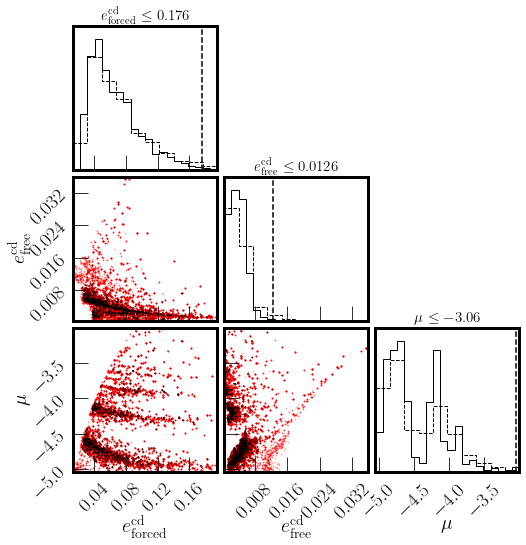

In [185]:
corner_plot(inres_params, spock_inres, threesig_inres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

In [191]:
print((10**threesig_inres[-1])/9.54e-4)

0.923086443126321


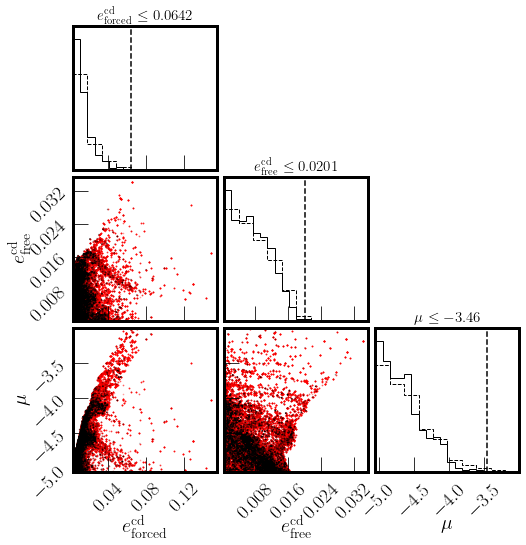

In [186]:
corner_plot(outres_params, spock_outres, threesig_outres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

In [194]:
print((10**threesig_outres[-1])/9.54e-4)

0.36562750848720116


## Time series panels

100it [00:01, 52.05it/s]


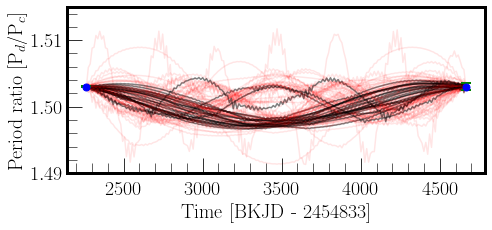

In [182]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    if spock_inres[i] != 0.0:
        ax.plot(time_grid,period_ratios,
             alpha=0.5,zorder=0, c='k',
             rasterized=True)
    elif spock_inres[i] == 0.0:
        ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='r',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='b',ecolor='g',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.515)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

100it [00:02, 45.34it/s]


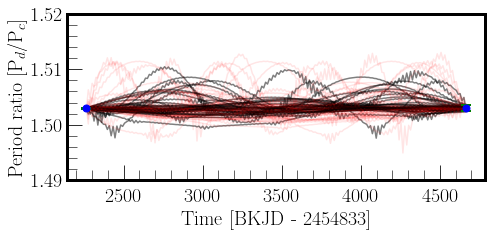

In [183]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_outres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    if spock_outres[i] != 0.0:
        ax.plot(time_grid,period_ratios,
             alpha=0.5,zorder=0, c='k',
             rasterized=True)
    elif spock_outres[i] == 0.0:
        ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='r',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='b',ecolor='g',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

# Figure 2

In [25]:
rv_inres_deltaT = [param[:4] for param in rv_inres]

In [26]:
j=3
k=1
phi_rv, Phinorm_rv = get_Phinorm(rv_inres_deltaT)


0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")

3it [00:00, 27.22it/s]
7it [00:00, 33.05it/s]
12it [00:00, 37.49it/s]
17it [00:00, 39.91it/s]
22it [00:00, 40.65it/s]
27it [00:00, 40.48it/s]
32it [00:00, 41.47it/s]
37it [00:00, 41.64it/s]
42it [00:01, 42.00it/s]
47it [00:01, 42.73it/s]
52it [00:01, 42.68it/s]
57it [00:01, 42.95it/s]
62it [00:01, 42.82it/s]
67it [00:01, 41.54it/s]
72it [00:01, 42.00it/s]
77it [00:01, 40.96it/s]
82it [00:02, 41.16it/s]
87it [00:02, 40.66it/s]
92it [00:02, 40.80it/s]
97it [00:02, 40.59it/s]
102it [00:02, 40.24it/s]
107it [00:02, 40.38it/s]
112it [00:02, 40.38it/s]
117it [00:02, 40.78it/s]
122it [00:02, 40.86it/s]
127it [00:03, 40.94it/s]
132it [00:03, 40.82it/s]
137it [00:03, 41.09it/s]
142it [00:03, 41.78it/s]
147it [00:03, 42.36it/s]
152it [00:03, 41.34it/s]
157it [00:03, 41.2

2822it [01:05, 43.84it/s]
2827it [01:05, 43.86it/s]
2832it [01:05, 42.05it/s]
2837it [01:05, 39.87it/s]
2842it [01:05, 41.15it/s]
2847it [01:06, 41.57it/s]
2852it [01:06, 41.71it/s]
2857it [01:06, 41.83it/s]
2862it [01:06, 42.14it/s]
2867it [01:06, 41.02it/s]
2872it [01:06, 40.28it/s]
2877it [01:06, 41.71it/s]
2882it [01:06, 42.20it/s]
2887it [01:07, 42.53it/s]
2892it [01:07, 42.82it/s]
2897it [01:07, 43.42it/s]
2902it [01:07, 43.40it/s]
2907it [01:07, 43.51it/s]
2912it [01:07, 43.65it/s]
2917it [01:07, 43.44it/s]
2922it [01:07, 43.82it/s]
2927it [01:07, 43.76it/s]
2932it [01:08, 43.61it/s]
2937it [01:08, 43.19it/s]
2942it [01:08, 43.18it/s]
2947it [01:08, 43.41it/s]
2952it [01:08, 43.60it/s]
2957it [01:08, 43.13it/s]
2962it [01:08, 43.94it/s]
2967it [01:08, 44.03it/s]
2972it [01:08, 43.80it/s]
2977it [01:09, 43.98it/s]
2982it [01:09, 43.62it/s]
2987it [01:09, 43.82it/s]
2992it [01:09, 43.93it/s]
2997it [01:09, 44.17it/s]
3002it [01:09, 44.03it/s]
3007it [01:09, 43.76it/s]
3012it [01:0

5642it [02:09, 42.63it/s]
5647it [02:09, 42.71it/s]
5652it [02:09, 43.01it/s]
5657it [02:10, 43.34it/s]
5662it [02:10, 43.67it/s]
5667it [02:10, 43.81it/s]
5672it [02:10, 43.68it/s]
5677it [02:10, 43.44it/s]
5682it [02:10, 43.71it/s]
5687it [02:10, 44.67it/s]
5692it [02:10, 44.80it/s]
5697it [02:10, 44.63it/s]
5702it [02:11, 44.73it/s]
5707it [02:11, 44.30it/s]
5712it [02:11, 44.39it/s]
5717it [02:11, 44.42it/s]
5722it [02:11, 44.24it/s]
5727it [02:11, 44.27it/s]
5732it [02:11, 44.35it/s]
5737it [02:11, 44.28it/s]
5742it [02:11, 44.42it/s]
5747it [02:12, 44.20it/s]
5752it [02:12, 44.09it/s]
5757it [02:12, 44.05it/s]
5762it [02:12, 44.52it/s]
5767it [02:12, 45.29it/s]
5772it [02:12, 44.90it/s]
5777it [02:12, 44.38it/s]
5782it [02:12, 43.97it/s]
5787it [02:12, 43.80it/s]
5792it [02:13, 44.01it/s]
5797it [02:13, 44.86it/s]
5802it [02:13, 44.86it/s]
5807it [02:13, 44.65it/s]
5812it [02:13, 44.57it/s]
5817it [02:13, 44.30it/s]
5822it [02:13, 44.11it/s]
5827it [02:13, 44.07it/s]
5832it [02:1

8461it [03:13, 44.31it/s]
8466it [03:13, 44.29it/s]
8471it [03:13, 42.89it/s]
8476it [03:14, 43.54it/s]
8481it [03:14, 42.98it/s]
8486it [03:14, 43.93it/s]
8491it [03:14, 44.41it/s]
8496it [03:14, 44.46it/s]
8501it [03:14, 43.01it/s]
8506it [03:14, 43.44it/s]
8511it [03:14, 43.72it/s]
8516it [03:14, 43.72it/s]
8521it [03:15, 43.76it/s]
8526it [03:15, 43.83it/s]
8531it [03:15, 44.41it/s]
8536it [03:15, 43.97it/s]
8541it [03:15, 44.13it/s]
8546it [03:15, 44.40it/s]
8551it [03:15, 44.83it/s]
8556it [03:15, 44.08it/s]
8561it [03:15, 43.54it/s]
8566it [03:16, 43.24it/s]
8571it [03:16, 43.69it/s]
8576it [03:16, 44.03it/s]
8581it [03:16, 44.43it/s]
8586it [03:16, 44.24it/s]
8591it [03:16, 44.30it/s]
8596it [03:16, 44.59it/s]
8601it [03:16, 44.06it/s]
8606it [03:17, 44.63it/s]
8611it [03:17, 44.24it/s]
8616it [03:17, 44.02it/s]
8621it [03:17, 44.05it/s]
8626it [03:17, 44.59it/s]
8631it [03:17, 44.90it/s]
8636it [03:17, 44.77it/s]
8641it [03:17, 44.52it/s]
8646it [03:17, 44.33it/s]
8651it [03:1

11236it [04:16, 44.09it/s]
11241it [04:16, 44.29it/s]
11246it [04:16, 44.30it/s]
11251it [04:16, 44.02it/s]
11256it [04:16, 44.67it/s]
11261it [04:17, 44.03it/s]
11266it [04:17, 43.98it/s]
11271it [04:17, 43.19it/s]
11276it [04:17, 43.21it/s]
11281it [04:17, 43.27it/s]
11286it [04:17, 43.20it/s]
11291it [04:17, 43.89it/s]
11296it [04:17, 44.34it/s]
11301it [04:17, 43.98it/s]
11306it [04:18, 44.19it/s]
11311it [04:18, 43.99it/s]
11316it [04:18, 44.08it/s]
11321it [04:18, 43.86it/s]
11326it [04:18, 43.92it/s]
11331it [04:18, 43.73it/s]
11336it [04:18, 43.80it/s]
11341it [04:18, 44.32it/s]
11346it [04:19, 43.60it/s]
11351it [04:19, 44.10it/s]
11356it [04:19, 43.99it/s]
11361it [04:19, 44.18it/s]
11366it [04:19, 43.92it/s]
11371it [04:19, 44.13it/s]
11376it [04:19, 44.19it/s]
11381it [04:19, 44.35it/s]
11386it [04:19, 44.42it/s]
11391it [04:20, 44.28it/s]
11396it [04:20, 44.17it/s]
11401it [04:20, 44.18it/s]
11406it [04:20, 43.90it/s]
11411it [04:20, 43.28it/s]
11416it [04:20, 43.59it/s]
1

13966it [05:18, 44.60it/s]
13971it [05:18, 43.76it/s]
13976it [05:18, 43.66it/s]
13981it [05:19, 43.51it/s]
13986it [05:19, 44.09it/s]
13991it [05:19, 44.39it/s]
13996it [05:19, 44.70it/s]
14001it [05:19, 44.51it/s]
14006it [05:19, 45.03it/s]
14011it [05:19, 45.82it/s]
14016it [05:19, 45.07it/s]
14021it [05:19, 44.74it/s]
14026it [05:20, 44.89it/s]
14031it [05:20, 44.05it/s]
14036it [05:20, 44.01it/s]
14041it [05:20, 44.48it/s]
14046it [05:20, 44.66it/s]
14051it [05:20, 44.61it/s]
14056it [05:20, 44.23it/s]
14061it [05:20, 44.35it/s]
14066it [05:20, 44.43it/s]
14071it [05:21, 44.53it/s]
14076it [05:21, 44.68it/s]
14081it [05:21, 44.28it/s]
14086it [05:21, 44.28it/s]
14091it [05:21, 44.27it/s]
14096it [05:21, 44.49it/s]
14101it [05:21, 44.03it/s]
14106it [05:21, 43.73it/s]
14111it [05:21, 44.27it/s]
14116it [05:22, 44.31it/s]
14121it [05:22, 44.41it/s]
14126it [05:22, 44.45it/s]
14131it [05:22, 44.99it/s]
14136it [05:22, 45.52it/s]
14141it [05:22, 45.49it/s]
14146it [05:22, 45.25it/s]
1

16696it [06:20, 44.48it/s]
16701it [06:20, 44.28it/s]
16706it [06:20, 44.22it/s]
16711it [06:20, 44.28it/s]
16716it [06:20, 44.34it/s]
16721it [06:20, 44.79it/s]
16726it [06:21, 44.15it/s]
16731it [06:21, 44.14it/s]
16736it [06:21, 44.65it/s]
16741it [06:21, 44.31it/s]
16746it [06:21, 44.21it/s]
16751it [06:21, 44.45it/s]
16756it [06:21, 44.46it/s]
16761it [06:21, 45.01it/s]
16766it [06:22, 45.18it/s]
16771it [06:22, 44.49it/s]
16776it [06:22, 44.69it/s]
16781it [06:22, 45.03it/s]
16786it [06:22, 44.69it/s]
16791it [06:22, 44.37it/s]
16796it [06:22, 44.79it/s]
16801it [06:22, 44.65it/s]
16806it [06:22, 45.21it/s]
16811it [06:23, 44.38it/s]
16816it [06:23, 44.58it/s]
16821it [06:23, 44.74it/s]
16826it [06:23, 44.26it/s]
16831it [06:23, 44.62it/s]
16836it [06:23, 43.86it/s]
16841it [06:23, 43.74it/s]
16846it [06:23, 43.90it/s]
16851it [06:23, 43.66it/s]
16856it [06:24, 44.13it/s]
16861it [06:24, 43.86it/s]
16866it [06:24, 44.48it/s]
16871it [06:24, 44.14it/s]
16876it [06:24, 44.23it/s]
1

19426it [07:22, 41.76it/s]
19431it [07:22, 41.47it/s]
19436it [07:22, 42.03it/s]
19441it [07:22, 42.49it/s]
19446it [07:22, 42.61it/s]
19451it [07:22, 43.21it/s]
19456it [07:22, 43.26it/s]
19461it [07:22, 39.73it/s]
19466it [07:22, 40.24it/s]
19471it [07:23, 41.05it/s]
19476it [07:23, 41.49it/s]
19481it [07:23, 42.78it/s]
19486it [07:23, 43.19it/s]
19491it [07:23, 43.38it/s]
19496it [07:23, 43.44it/s]
19501it [07:23, 44.37it/s]
19506it [07:23, 43.69it/s]
19511it [07:24, 44.06it/s]
19516it [07:24, 44.73it/s]
19521it [07:24, 44.34it/s]
19526it [07:24, 44.52it/s]
19531it [07:24, 44.66it/s]
19536it [07:24, 44.64it/s]
19541it [07:24, 43.92it/s]
19546it [07:24, 43.56it/s]
19551it [07:24, 43.14it/s]
19556it [07:25, 43.56it/s]
19561it [07:25, 44.04it/s]
19566it [07:25, 44.26it/s]
19571it [07:25, 44.13it/s]
19576it [07:25, 44.53it/s]
19581it [07:25, 44.14it/s]
19586it [07:25, 43.87it/s]
19591it [07:25, 44.37it/s]
19596it [07:25, 44.32it/s]
19601it [07:26, 44.26it/s]
19606it [07:26, 44.33it/s]
1

In [228]:
#np.save('stability_posteriors/phi_rv.npy', phi_rv)
#np.save('stability_posteriors/Phinorm_rv.npy', Phinorm_rv)

<ipython-input-146-b6ad535e4381>:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)


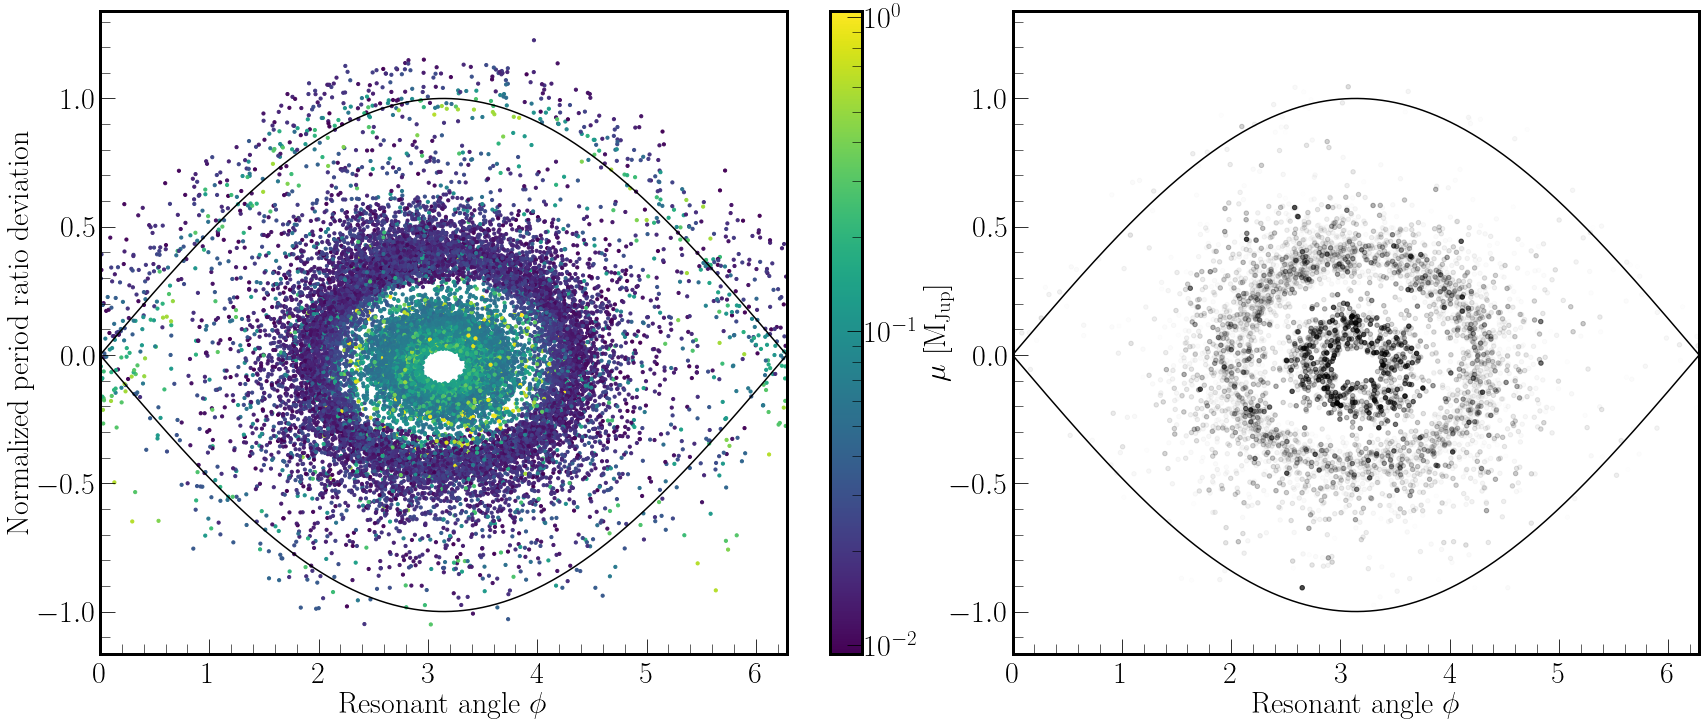

In [146]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7*3.4, 4.0*3.4*3/4.),
                         gridspec_kw={'width_ratios': [1, 0.80]})
ax1 = axes[0]
ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)
mu_mjup = np.array([(10**(param[2]))/9.54e-4 for param in rv_inres])

cb=ax1.scatter(phi_rv, Phinorm_rv, 
              c=mu_mjup,norm=colors.LogNorm(vmin=mu_mjup.min(), vmax=mu_mjup.max()),
              s=10, rasterized=True)
#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[param[2] for param in rv_inres], 
#              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv, Phinorm_rv, 
              alpha=[prob for prob in spock_inres],c='k', 
              s=20) 

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
#plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

# Figure 3

In [30]:
mb_array = (10**np.array([rv_post[i][-2] for i in range(len(rv_post))]))/9.54e-4
eb_array = np.array([rv_post[i][-1] for i in range(len(rv_post))])

In [31]:
print('Stable resonant:',len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] >= 0]))

Stable resonant: 184
Stable non-resonant: 27986


In [32]:
print('Unstable resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] >= 0]))

Unstable resonant: 6706
Unstable non-resonant: 65124


In [33]:
mb_array_logu = (10**np.array([logu_post[i][-2] for i in range(len(logu_post))]))/9.54e-4
eb_array_logu = np.array([logu_post[i][-1] for i in range(len(logu_post))])

In [34]:
deltaH_cd_logu = get_deltaH(logu_post,j=3, k=1, i1=1, i2=2)
deltaH_db_logu = get_deltaH(logu_post,j=2, k=1, i1=2, i2=3)

#np.save('stability_posteriors/deltaH_cd_logu.npy',deltaH_cd_logu)
#np.save('stability_posteriors/deltaH_db_logu.npy',deltaH_db_logu)


0it [00:00, ?it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")

8it [00:00, 79.77it/s]
16it [00:00, 79.29it/s]
25it [00:00, 82.76it/s]
34it [00:00, 81.09it/s]
43it [00:00, 83.01it/s]
52it [00:00, 82.19it/s]
61it [00:00, 81.68it/s]
70it [00:00, 82.55it/s]
79it [00:00, 82.51it/s]
88it [00:01, 80.82it/s]
97it [00:01, 81.08it/s]
106it [00:01, 81.65it/s]
115it [00:01, 81.70it/s]
124it [00:01, 80.50it/s]
133it [00:01, 80.80it/s]
142it [00:01, 80.63it/s]
151it [00:01, 80.73it/s]
160it [00:01, 80.42it/s]
169it [00:02, 78.96it/s]
177it [00:02, 76.21it/s]
185it [00:02, 74.89it/s]
193it [00:02, 7

4885it [00:59, 84.11it/s]
4894it [00:59, 83.56it/s]
4903it [00:59, 84.49it/s]
4912it [00:59, 84.20it/s]
4921it [00:59, 84.22it/s]
4930it [01:00, 83.98it/s]
4939it [01:00, 85.18it/s]
4948it [01:00, 85.40it/s]
4957it [01:00, 85.01it/s]
4966it [01:00, 84.18it/s]
4975it [01:00, 84.61it/s]
4984it [01:00, 85.38it/s]
4993it [01:00, 85.87it/s]
5002it [01:00, 84.19it/s]
5011it [01:00, 84.95it/s]
5020it [01:01, 85.43it/s]
5030it [01:01, 87.26it/s]
5039it [01:01, 86.27it/s]
5048it [01:01, 86.23it/s]
5057it [01:01, 85.66it/s]
5066it [01:01, 85.23it/s]
5075it [01:01, 83.94it/s]
5084it [01:01, 83.45it/s]
5093it [01:01, 84.35it/s]
5102it [01:02, 84.86it/s]
5111it [01:02, 83.14it/s]
5120it [01:02, 84.28it/s]
5129it [01:02, 83.86it/s]
5138it [01:02, 84.54it/s]
5147it [01:02, 85.21it/s]
5156it [01:02, 85.61it/s]
5165it [01:02, 85.75it/s]
5174it [01:02, 85.21it/s]
5183it [01:03, 86.17it/s]
5192it [01:03, 85.81it/s]
5201it [01:03, 85.74it/s]
5210it [01:03, 86.57it/s]
5219it [01:03, 86.97it/s]
5228it [01:0

9963it [01:59, 84.23it/s]
9972it [01:59, 83.43it/s]
9981it [02:00, 84.24it/s]
9990it [02:00, 82.53it/s]
9999it [02:00, 81.52it/s]
10008it [02:00, 81.46it/s]
10017it [02:00, 82.19it/s]
10026it [02:00, 83.22it/s]
10035it [02:00, 81.95it/s]
10044it [02:00, 82.86it/s]
10053it [02:00, 82.48it/s]
10062it [02:01, 82.42it/s]
10071it [02:01, 83.25it/s]
10080it [02:01, 83.96it/s]
10089it [02:01, 83.07it/s]
10098it [02:01, 77.17it/s]
10107it [02:01, 78.53it/s]
10115it [02:01, 78.22it/s]
10124it [02:01, 80.47it/s]
10133it [02:01, 80.33it/s]
10142it [02:02, 79.26it/s]
10151it [02:02, 80.97it/s]
10160it [02:02, 81.23it/s]
10169it [02:02, 82.80it/s]
10178it [02:02, 83.57it/s]
10187it [02:02, 83.40it/s]
10196it [02:02, 82.65it/s]
10205it [02:02, 82.82it/s]
10214it [02:02, 82.89it/s]
10223it [02:02, 83.77it/s]
10232it [02:03, 82.76it/s]
10241it [02:03, 83.39it/s]
10250it [02:03, 82.94it/s]
10259it [02:03, 83.43it/s]
10268it [02:03, 84.35it/s]
10277it [02:03, 84.10it/s]
10286it [02:03, 84.62it/s]
10295i

14895it [02:57, 83.28it/s]
14904it [02:57, 83.27it/s]
14913it [02:57, 83.14it/s]
14922it [02:57, 83.73it/s]
14931it [02:58, 84.07it/s]
14940it [02:58, 79.13it/s]
14949it [02:58, 80.96it/s]
14958it [02:58, 81.21it/s]
14967it [02:58, 82.04it/s]
14976it [02:58, 82.93it/s]
14985it [02:58, 82.19it/s]
14994it [02:58, 81.58it/s]
15003it [02:58, 81.49it/s]
15012it [02:59, 82.26it/s]
15021it [02:59, 81.44it/s]
15030it [02:59, 80.99it/s]
15039it [02:59, 82.12it/s]
15048it [02:59, 80.79it/s]
15057it [02:59, 80.12it/s]
15066it [02:59, 80.02it/s]
15075it [02:59, 80.63it/s]
15084it [02:59, 81.47it/s]
15093it [03:00, 81.62it/s]
15102it [03:00, 81.77it/s]
15111it [03:00, 80.84it/s]
15120it [03:00, 81.63it/s]
15129it [03:00, 80.53it/s]
15138it [03:00, 81.22it/s]
15147it [03:00, 81.84it/s]
15156it [03:00, 83.08it/s]
15165it [03:00, 84.78it/s]
15175it [03:01, 86.67it/s]
15184it [03:01, 85.86it/s]
15193it [03:01, 85.95it/s]
15202it [03:01, 85.05it/s]
15211it [03:01, 84.37it/s]
15220it [03:01, 85.74it/s]
1

19747it [03:56, 85.88it/s]
19756it [03:56, 85.44it/s]
19765it [03:56, 84.69it/s]
19774it [03:56, 84.71it/s]
19783it [03:56, 85.37it/s]
19792it [03:57, 83.56it/s]
19801it [03:57, 84.75it/s]
19810it [03:57, 85.59it/s]
19819it [03:57, 84.25it/s]
19828it [03:57, 85.06it/s]
19838it [03:57, 86.61it/s]
19847it [03:57, 86.68it/s]
19856it [03:57, 86.55it/s]
19865it [03:57, 85.79it/s]
19874it [03:58, 84.97it/s]
19883it [03:58, 84.05it/s]
19892it [03:58, 84.66it/s]
19901it [03:58, 84.98it/s]
19910it [03:58, 85.67it/s]
19920it [03:58, 87.26it/s]
19929it [03:58, 85.32it/s]
19938it [03:58, 85.88it/s]
19947it [03:58, 86.28it/s]
19956it [03:58, 87.01it/s]
19965it [03:59, 87.31it/s]
19974it [03:59, 87.63it/s]
19983it [03:59, 87.11it/s]
19992it [03:59, 86.87it/s]
20001it [03:59, 86.34it/s]
20011it [03:59, 87.76it/s]
20020it [03:59, 86.62it/s]
20029it [03:59, 86.33it/s]
20038it [03:59, 86.73it/s]
20047it [04:00, 86.24it/s]
20056it [04:00, 86.63it/s]
20065it [04:00, 86.78it/s]
20074it [04:00, 87.56it/s]
2

24593it [04:56, 81.95it/s]
24602it [04:56, 84.11it/s]
24612it [04:56, 86.77it/s]
24621it [04:56, 75.64it/s]
24630it [04:57, 78.11it/s]
24639it [04:57, 67.00it/s]
24647it [04:57, 66.44it/s]
24654it [04:57, 67.19it/s]
24663it [04:57, 71.47it/s]
24672it [04:57, 76.38it/s]
24681it [04:57, 79.38it/s]
24691it [04:57, 83.08it/s]
24700it [04:57, 84.12it/s]
24709it [04:58, 84.15it/s]
24718it [04:58, 85.28it/s]
24727it [04:58, 85.70it/s]
24736it [04:58, 86.33it/s]
24745it [04:58, 87.26it/s]
24755it [04:58, 88.99it/s]
24765it [04:58, 89.84it/s]
24774it [04:58, 89.44it/s]
24784it [04:58, 91.09it/s]
24794it [04:59, 90.55it/s]
24804it [04:59, 90.17it/s]
24814it [04:59, 90.82it/s]
24824it [04:59, 91.62it/s]
24834it [04:59, 92.53it/s]
24844it [04:59, 92.91it/s]
24854it [04:59, 92.12it/s]
24864it [04:59, 92.02it/s]
24874it [04:59, 91.61it/s]
24884it [05:00, 91.25it/s]
24894it [05:00, 88.24it/s]
24903it [05:00, 87.85it/s]
24912it [05:00, 87.61it/s]
24921it [05:00, 87.74it/s]
24930it [05:00, 87.99it/s]
2

29861it [05:55, 92.45it/s]
29871it [05:56, 92.49it/s]
29881it [05:56, 86.76it/s]
29891it [05:56, 88.53it/s]
29900it [05:56, 88.91it/s]
29910it [05:56, 89.67it/s]
29920it [05:56, 90.45it/s]
29930it [05:56, 91.04it/s]
29940it [05:56, 91.85it/s]
29950it [05:56, 91.73it/s]
29960it [05:57, 90.86it/s]
29970it [05:57, 91.14it/s]
29980it [05:57, 91.18it/s]
29990it [05:57, 90.82it/s]
30000it [05:57, 91.57it/s]
30010it [05:57, 92.12it/s]
30020it [05:57, 91.90it/s]
30030it [05:57, 92.40it/s]
30040it [05:57, 91.56it/s]
30050it [05:58, 92.00it/s]
30060it [05:58, 91.20it/s]
30070it [05:58, 91.76it/s]
30080it [05:58, 91.76it/s]
30090it [05:58, 92.39it/s]
30100it [05:58, 92.49it/s]
30110it [05:58, 92.54it/s]
30120it [05:58, 92.34it/s]
30130it [05:58, 92.56it/s]
30140it [05:58, 93.02it/s]
30150it [05:59, 92.57it/s]
30160it [05:59, 92.33it/s]
30170it [05:59, 92.56it/s]
30180it [05:59, 93.03it/s]
30190it [05:59, 92.56it/s]
30200it [05:59, 92.59it/s]
30210it [05:59, 92.48it/s]
30220it [05:59, 92.38it/s]
3

35201it [06:55, 91.72it/s]
35211it [06:55, 91.49it/s]
35221it [06:55, 91.52it/s]
35231it [06:55, 92.11it/s]
35241it [06:55, 92.07it/s]
35251it [06:55, 92.62it/s]
35261it [06:55, 92.44it/s]
35271it [06:55, 92.14it/s]
35281it [06:55, 92.49it/s]
35291it [06:56, 92.57it/s]
35301it [06:56, 92.45it/s]
35311it [06:56, 92.74it/s]
35321it [06:56, 92.66it/s]
35331it [06:56, 92.32it/s]
35341it [06:56, 91.94it/s]
35351it [06:56, 92.13it/s]
35361it [06:56, 92.41it/s]
35371it [06:56, 92.35it/s]
35381it [06:57, 92.70it/s]
35391it [06:57, 92.25it/s]
35401it [06:57, 92.28it/s]
35411it [06:57, 91.95it/s]
35421it [06:57, 91.20it/s]
35431it [06:57, 90.99it/s]
35441it [06:57, 91.11it/s]
35451it [06:57, 91.76it/s]
35461it [06:57, 91.76it/s]
35471it [06:58, 92.05it/s]
35481it [06:58, 91.89it/s]
35491it [06:58, 91.99it/s]
35501it [06:58, 91.59it/s]
35511it [06:58, 91.71it/s]
35521it [06:58, 91.90it/s]
35531it [06:58, 91.99it/s]
35541it [06:58, 91.81it/s]
35551it [06:58, 91.68it/s]
35561it [06:59, 91.24it/s]
3

40600it [07:54, 91.36it/s]
40610it [07:54, 91.68it/s]
40620it [07:54, 88.92it/s]
40629it [07:54, 85.95it/s]
40639it [07:54, 87.53it/s]
40649it [07:55, 88.84it/s]
40659it [07:55, 90.13it/s]
40669it [07:55, 90.79it/s]
40679it [07:55, 90.86it/s]
40689it [07:55, 90.77it/s]
40699it [07:55, 91.17it/s]
40709it [07:55, 91.59it/s]
40719it [07:55, 92.38it/s]
40729it [07:55, 92.99it/s]
40739it [07:55, 93.18it/s]
40749it [07:56, 92.50it/s]
40759it [07:56, 92.77it/s]
40769it [07:56, 92.73it/s]
40779it [07:56, 91.64it/s]
40789it [07:56, 91.21it/s]
40799it [07:56, 91.72it/s]
40809it [07:56, 91.95it/s]
40819it [07:56, 91.94it/s]
40829it [07:56, 91.91it/s]
40839it [07:57, 91.56it/s]
40849it [07:57, 92.23it/s]
40859it [07:57, 92.17it/s]
40869it [07:57, 92.14it/s]
40879it [07:57, 92.21it/s]
40889it [07:57, 92.90it/s]
40899it [07:57, 92.78it/s]
40909it [07:57, 93.06it/s]
40919it [07:57, 92.40it/s]
40929it [07:58, 91.68it/s]
40939it [07:58, 91.57it/s]
40949it [07:58, 92.00it/s]
40959it [07:58, 92.46it/s]
4

45982it [08:53, 91.34it/s]
45992it [08:53, 91.11it/s]
46002it [08:53, 91.32it/s]
46012it [08:53, 91.01it/s]
46022it [08:54, 91.06it/s]
46032it [08:54, 91.81it/s]
46042it [08:54, 91.76it/s]
46052it [08:54, 91.80it/s]
46062it [08:54, 92.18it/s]
46072it [08:54, 92.05it/s]
46082it [08:54, 92.38it/s]
46092it [08:54, 92.26it/s]
46102it [08:54, 92.45it/s]
46112it [08:55, 92.64it/s]
46122it [08:55, 92.25it/s]
46132it [08:55, 91.92it/s]
46142it [08:55, 92.39it/s]
46152it [08:55, 92.50it/s]
46162it [08:55, 92.54it/s]
46172it [08:55, 92.24it/s]
46182it [08:55, 92.14it/s]
46192it [08:55, 92.24it/s]
46202it [08:56, 85.91it/s]
46212it [08:56, 88.19it/s]
46222it [08:56, 89.33it/s]
46232it [08:56, 90.20it/s]
46242it [08:56, 90.68it/s]
46252it [08:56, 91.07it/s]
46262it [08:56, 91.68it/s]
46272it [08:56, 91.71it/s]
46282it [08:56, 92.12it/s]
46292it [08:57, 92.45it/s]
46302it [08:57, 92.56it/s]
46312it [08:57, 92.52it/s]
46322it [08:57, 92.08it/s]
46332it [08:57, 91.06it/s]
46342it [08:57, 91.19it/s]
4

51368it [09:53, 85.27it/s]
51378it [09:53, 87.14it/s]
51388it [09:53, 88.95it/s]
51398it [09:53, 89.75it/s]
51408it [09:53, 90.36it/s]
51418it [09:53, 90.85it/s]
51428it [09:53, 91.13it/s]
51438it [09:54, 83.81it/s]
51447it [09:54, 81.88it/s]
51456it [09:54, 81.39it/s]
51465it [09:54, 82.32it/s]
51474it [09:54, 83.04it/s]
51483it [09:54, 83.23it/s]
51492it [09:54, 83.75it/s]
51501it [09:54, 83.77it/s]
51510it [09:54, 84.41it/s]
51519it [09:54, 84.02it/s]
51528it [09:55, 83.81it/s]
51537it [09:55, 84.36it/s]
51546it [09:55, 84.12it/s]
51555it [09:55, 83.47it/s]
51564it [09:55, 83.10it/s]
51573it [09:55, 82.17it/s]
51582it [09:55, 81.60it/s]
51591it [09:55, 81.78it/s]
51600it [09:55, 81.59it/s]
51609it [09:56, 81.37it/s]
51618it [09:56, 82.04it/s]
51627it [09:56, 75.87it/s]
51635it [09:56, 76.76it/s]
51644it [09:56, 78.41it/s]
51653it [09:56, 79.42it/s]
51662it [09:56, 81.48it/s]
51671it [09:56, 82.71it/s]
51680it [09:56, 83.44it/s]
51689it [09:57, 84.51it/s]
51698it [09:57, 84.48it/s]
5

56604it [10:52, 87.09it/s]
56613it [10:52, 87.16it/s]
56622it [10:52, 87.23it/s]
56631it [10:52, 87.30it/s]
56640it [10:52, 86.58it/s]
56649it [10:52, 85.64it/s]
56658it [10:53, 84.17it/s]
56667it [10:53, 85.05it/s]
56676it [10:53, 86.23it/s]
56685it [10:53, 85.86it/s]
56694it [10:53, 86.69it/s]
56704it [10:53, 88.17it/s]
56713it [10:53, 88.10it/s]
56722it [10:53, 88.44it/s]
56731it [10:53, 87.75it/s]
56740it [10:53, 87.38it/s]
56749it [10:54, 86.47it/s]
56758it [10:54, 81.69it/s]
56767it [10:54, 83.39it/s]
56777it [10:54, 86.37it/s]
56787it [10:54, 87.73it/s]
56796it [10:54, 87.69it/s]
56805it [10:54, 87.20it/s]
56814it [10:54, 86.74it/s]
56823it [10:54, 87.57it/s]
56833it [10:55, 88.84it/s]
56842it [10:55, 88.65it/s]
56852it [10:55, 89.23it/s]
56862it [10:55, 90.70it/s]
56872it [10:55, 90.59it/s]
56882it [10:55, 91.14it/s]
56892it [10:55, 91.59it/s]
56902it [10:55, 90.34it/s]
56912it [10:55, 89.05it/s]
56921it [10:56, 88.09it/s]
56930it [10:56, 88.01it/s]
56940it [10:56, 89.05it/s]
5

61800it [11:51, 88.25it/s]
61809it [11:51, 87.37it/s]
61818it [11:51, 87.63it/s]
61827it [11:51, 88.09it/s]
61836it [11:52, 87.87it/s]
61845it [11:52, 87.87it/s]
61854it [11:52, 87.56it/s]
61864it [11:52, 88.45it/s]
61873it [11:52, 88.14it/s]
61882it [11:52, 88.19it/s]
61891it [11:52, 87.20it/s]
61900it [11:52, 87.46it/s]
61909it [11:52, 87.93it/s]
61919it [11:52, 88.84it/s]
61928it [11:53, 87.27it/s]
61937it [11:53, 87.38it/s]
61946it [11:53, 87.89it/s]
61956it [11:53, 88.62it/s]
61965it [11:53, 88.64it/s]
61974it [11:53, 88.76it/s]
61983it [11:53, 88.50it/s]
61992it [11:53, 88.65it/s]
62001it [11:53, 88.69it/s]
62010it [11:54, 88.01it/s]
62019it [11:54, 88.54it/s]
62028it [11:54, 87.53it/s]
62037it [11:54, 83.87it/s]
62046it [11:54, 83.60it/s]
62056it [11:54, 86.47it/s]
62066it [11:54, 88.14it/s]
62076it [11:54, 89.33it/s]
62086it [11:54, 90.26it/s]
62096it [11:55, 90.70it/s]
62106it [11:55, 91.03it/s]
62116it [11:55, 90.90it/s]
62126it [11:55, 91.54it/s]
62136it [11:55, 91.97it/s]
6

67183it [12:50, 91.64it/s]
67193it [12:50, 92.22it/s]
67203it [12:51, 91.57it/s]
67213it [12:51, 92.02it/s]
67223it [12:51, 91.93it/s]
67233it [12:51, 87.16it/s]
67242it [12:51, 87.14it/s]
67252it [12:51, 88.71it/s]
67262it [12:51, 89.93it/s]
67272it [12:51, 90.67it/s]
67282it [12:51, 90.93it/s]
67292it [12:52, 89.97it/s]
67302it [12:52, 89.96it/s]
67312it [12:52, 90.93it/s]
67322it [12:52, 91.10it/s]
67332it [12:52, 91.50it/s]
67342it [12:52, 91.84it/s]
67352it [12:52, 91.73it/s]
67362it [12:52, 92.14it/s]
67372it [12:52, 91.92it/s]
67382it [12:53, 91.88it/s]
67392it [12:53, 92.08it/s]
67402it [12:53, 92.03it/s]
67412it [12:53, 91.80it/s]
67422it [12:53, 90.88it/s]
67432it [12:53, 89.47it/s]
67442it [12:53, 90.31it/s]
67452it [12:53, 90.61it/s]
67462it [12:53, 84.80it/s]
67472it [12:54, 87.32it/s]
67482it [12:54, 89.04it/s]
67492it [12:54, 89.69it/s]
67502it [12:54, 90.87it/s]
67512it [12:54, 91.23it/s]
67522it [12:54, 91.64it/s]
67532it [12:54, 91.80it/s]
67542it [12:54, 91.89it/s]
6

72557it [13:50, 91.08it/s]
72567it [13:50, 91.09it/s]
72577it [13:50, 91.75it/s]
72587it [13:50, 92.37it/s]
72597it [13:50, 92.40it/s]
72607it [13:50, 92.34it/s]
72617it [13:50, 91.88it/s]
72627it [13:50, 91.92it/s]
72637it [13:50, 91.95it/s]
72647it [13:51, 92.00it/s]
72657it [13:51, 92.06it/s]
72667it [13:51, 92.32it/s]
72677it [13:51, 92.63it/s]
72687it [13:51, 92.73it/s]
72697it [13:51, 92.70it/s]
72707it [13:51, 92.63it/s]
72717it [13:51, 91.90it/s]
72727it [13:51, 91.96it/s]
72737it [13:52, 91.13it/s]
72747it [13:52, 91.03it/s]
72757it [13:52, 90.85it/s]
72767it [13:52, 91.23it/s]
72777it [13:52, 91.45it/s]
72787it [13:52, 91.59it/s]
72797it [13:52, 91.67it/s]
72807it [13:52, 91.87it/s]
72817it [13:52, 91.75it/s]
72827it [13:53, 91.94it/s]
72837it [13:53, 91.85it/s]
72847it [13:53, 91.99it/s]
72857it [13:53, 92.43it/s]
72867it [13:53, 92.12it/s]
72877it [13:53, 92.52it/s]
72887it [13:53, 92.87it/s]
72897it [13:53, 92.36it/s]
72907it [13:53, 92.44it/s]
72917it [13:54, 92.14it/s]
7

77920it [14:49, 90.17it/s]
77930it [14:49, 90.86it/s]
77940it [14:49, 91.08it/s]
77950it [14:49, 91.71it/s]
77960it [14:49, 92.39it/s]
77970it [14:49, 92.59it/s]
77980it [14:49, 92.42it/s]
77990it [14:49, 91.87it/s]
78000it [14:50, 92.23it/s]
78010it [14:50, 91.81it/s]
78020it [14:50, 91.82it/s]
78030it [14:50, 92.24it/s]
78040it [14:50, 89.24it/s]
78049it [14:50, 86.58it/s]
78059it [14:50, 88.56it/s]
78069it [14:50, 89.26it/s]
78079it [14:50, 90.03it/s]
78089it [14:51, 90.55it/s]
78099it [14:51, 90.97it/s]
78109it [14:51, 91.53it/s]
78119it [14:51, 91.68it/s]
78129it [14:51, 91.78it/s]
78139it [14:51, 92.10it/s]
78149it [14:51, 92.60it/s]
78159it [14:51, 92.31it/s]
78169it [14:51, 92.51it/s]
78179it [14:52, 92.36it/s]
78189it [14:52, 90.95it/s]
78199it [14:52, 91.17it/s]
78209it [14:52, 90.73it/s]
78219it [14:52, 90.98it/s]
78229it [14:52, 91.61it/s]
78239it [14:52, 91.60it/s]
78249it [14:52, 92.12it/s]
78259it [14:52, 92.02it/s]
78269it [14:52, 91.59it/s]
78279it [14:53, 91.10it/s]
7

83123it [15:48, 89.55it/s]
83132it [15:48, 89.55it/s]
83141it [15:49, 89.38it/s]
83150it [15:49, 88.80it/s]
83160it [15:49, 89.93it/s]
83169it [15:49, 89.63it/s]
83179it [15:49, 90.63it/s]
83189it [15:49, 89.80it/s]
83198it [15:49, 89.70it/s]
83208it [15:49, 90.64it/s]
83218it [15:49, 90.53it/s]
83228it [15:49, 90.96it/s]
83238it [15:50, 90.91it/s]
83248it [15:50, 90.74it/s]
83258it [15:50, 91.00it/s]
83268it [15:50, 90.77it/s]
83278it [15:50, 90.71it/s]
83288it [15:50, 91.14it/s]
83298it [15:50, 91.17it/s]
83308it [15:50, 91.62it/s]
83318it [15:50, 91.72it/s]
83328it [15:51, 90.54it/s]
83338it [15:51, 86.45it/s]
83347it [15:51, 83.27it/s]
83356it [15:51, 82.10it/s]
83365it [15:51, 83.16it/s]
83374it [15:51, 83.84it/s]
83383it [15:51, 82.21it/s]
83392it [15:51, 81.47it/s]
83401it [15:51, 80.82it/s]
83410it [15:52, 82.61it/s]
83419it [15:52, 83.94it/s]
83428it [15:52, 83.77it/s]
83437it [15:52, 83.38it/s]
83446it [15:52, 84.97it/s]
83456it [15:52, 87.12it/s]
83465it [15:52, 85.73it/s]
8

88028it [16:49, 88.22it/s]
88038it [16:49, 89.18it/s]
88047it [16:50, 89.41it/s]
88057it [16:50, 89.85it/s]
88066it [16:50, 87.76it/s]
88075it [16:50, 86.23it/s]
88084it [16:50, 85.36it/s]
88094it [16:50, 87.17it/s]
88104it [16:50, 89.31it/s]
88114it [16:50, 90.77it/s]
88124it [16:50, 89.83it/s]
88134it [16:51, 91.27it/s]
88144it [16:51, 92.27it/s]
88154it [16:51, 92.99it/s]
88164it [16:51, 93.29it/s]
88174it [16:51, 92.66it/s]
88184it [16:51, 91.01it/s]
88194it [16:51, 89.47it/s]
88203it [16:51, 89.32it/s]
88213it [16:51, 89.96it/s]
88223it [16:52, 90.88it/s]
88233it [16:52, 89.40it/s]
88242it [16:52, 87.86it/s]
88251it [16:52, 87.26it/s]
88261it [16:52, 89.04it/s]
88271it [16:52, 90.56it/s]
88281it [16:52, 91.50it/s]
88291it [16:52, 92.51it/s]
88301it [16:52, 92.23it/s]
88311it [16:53, 92.05it/s]
88321it [16:53, 91.33it/s]
88331it [16:53, 92.13it/s]
88341it [16:53, 92.52it/s]
88351it [16:53, 86.10it/s]
88360it [16:53, 85.33it/s]
88369it [16:53, 86.40it/s]
88379it [16:53, 88.54it/s]
8

93226it [17:49, 90.89it/s]
93236it [17:49, 91.80it/s]
93246it [17:49, 92.69it/s]
93256it [17:49, 93.60it/s]
93266it [17:49, 93.68it/s]
93276it [17:49, 93.58it/s]
93286it [17:49, 92.94it/s]
93296it [17:49, 93.16it/s]
93306it [17:49, 93.34it/s]
93316it [17:50, 93.02it/s]
93326it [17:50, 92.87it/s]
93336it [17:50, 92.86it/s]
93346it [17:50, 92.76it/s]
93356it [17:50, 92.44it/s]
93366it [17:50, 92.51it/s]
93376it [17:50, 91.75it/s]
93386it [17:50, 92.04it/s]
93396it [17:50, 92.12it/s]
93406it [17:51, 92.30it/s]
93416it [17:51, 92.11it/s]
93426it [17:51, 91.62it/s]
93436it [17:51, 92.13it/s]
93446it [17:51, 92.72it/s]
93456it [17:51, 92.78it/s]
93466it [17:51, 92.44it/s]
93476it [17:51, 92.32it/s]
93486it [17:51, 91.76it/s]
93496it [17:52, 92.25it/s]
93506it [17:52, 92.19it/s]
93516it [17:52, 92.44it/s]
93526it [17:52, 92.22it/s]
93536it [17:52, 92.27it/s]
93546it [17:52, 90.85it/s]
93556it [17:52, 86.98it/s]
93565it [17:52, 83.64it/s]
93574it [17:52, 82.59it/s]
93583it [17:53, 82.28it/s]
9

98362it [18:48, 85.61it/s]
98371it [18:49, 85.13it/s]
98380it [18:49, 84.95it/s]
98389it [18:49, 85.73it/s]
98398it [18:49, 84.57it/s]
98407it [18:49, 84.51it/s]
98416it [18:49, 84.75it/s]
98425it [18:49, 83.31it/s]
98434it [18:49, 83.93it/s]
98443it [18:49, 84.79it/s]
98452it [18:50, 85.70it/s]
98461it [18:50, 86.12it/s]
98470it [18:50, 85.96it/s]
98479it [18:50, 86.22it/s]
98488it [18:50, 85.40it/s]
98497it [18:50, 85.46it/s]
98506it [18:50, 85.88it/s]
98515it [18:50, 85.14it/s]
98524it [18:50, 85.02it/s]
98533it [18:50, 85.60it/s]
98542it [18:51, 86.14it/s]
98551it [18:51, 86.56it/s]
98560it [18:51, 86.57it/s]
98569it [18:51, 87.16it/s]
98578it [18:51, 87.01it/s]
98588it [18:51, 88.77it/s]
98598it [18:51, 89.92it/s]
98607it [18:51, 88.71it/s]
98617it [18:51, 89.20it/s]
98626it [18:52, 89.16it/s]
98635it [18:52, 89.28it/s]
98645it [18:52, 90.21it/s]
98655it [18:52, 89.82it/s]
98664it [18:52, 89.71it/s]
98674it [18:52, 90.41it/s]
98684it [18:52, 90.41it/s]
98694it [18:52, 90.98it/s]
9

3496it [00:41, 86.70it/s]
3505it [00:41, 87.22it/s]
3514it [00:41, 86.61it/s]
3523it [00:41, 84.21it/s]
3532it [00:41, 84.03it/s]
3541it [00:41, 84.02it/s]
3550it [00:41, 84.43it/s]
3559it [00:42, 85.72it/s]
3568it [00:42, 86.08it/s]
3577it [00:42, 83.31it/s]
3586it [00:42, 84.37it/s]
3595it [00:42, 84.91it/s]
3604it [00:42, 85.55it/s]
3613it [00:42, 85.85it/s]
3622it [00:42, 85.93it/s]
3631it [00:42, 86.41it/s]
3640it [00:42, 86.44it/s]
3649it [00:43, 86.50it/s]
3658it [00:43, 86.38it/s]
3667it [00:43, 84.52it/s]
3676it [00:43, 84.93it/s]
3685it [00:43, 84.42it/s]
3694it [00:43, 84.46it/s]
3703it [00:43, 85.30it/s]
3712it [00:43, 84.85it/s]
3721it [00:43, 85.50it/s]
3730it [00:44, 85.36it/s]
3739it [00:44, 85.71it/s]
3748it [00:44, 85.82it/s]
3757it [00:44, 85.18it/s]
3766it [00:44, 84.83it/s]
3775it [00:44, 84.93it/s]
3784it [00:44, 85.09it/s]
3793it [00:44, 83.26it/s]
3802it [00:44, 77.70it/s]
3811it [00:45, 79.35it/s]
3820it [00:45, 80.28it/s]
3829it [00:45, 81.33it/s]
3838it [00:4

8547it [01:41, 84.20it/s]
8556it [01:41, 84.07it/s]
8565it [01:41, 84.18it/s]
8574it [01:41, 84.94it/s]
8583it [01:41, 85.08it/s]
8592it [01:42, 85.73it/s]
8601it [01:42, 85.20it/s]
8610it [01:42, 85.83it/s]
8619it [01:42, 85.82it/s]
8628it [01:42, 85.84it/s]
8637it [01:42, 86.22it/s]
8646it [01:42, 85.75it/s]
8655it [01:42, 86.36it/s]
8664it [01:42, 87.04it/s]
8673it [01:42, 86.78it/s]
8682it [01:43, 86.94it/s]
8691it [01:43, 86.71it/s]
8700it [01:43, 86.69it/s]
8709it [01:43, 85.89it/s]
8718it [01:43, 86.13it/s]
8727it [01:43, 86.02it/s]
8736it [01:43, 86.11it/s]
8745it [01:43, 86.43it/s]
8754it [01:43, 86.61it/s]
8763it [01:44, 86.57it/s]
8772it [01:44, 86.77it/s]
8781it [01:44, 86.94it/s]
8790it [01:44, 87.41it/s]
8799it [01:44, 87.35it/s]
8808it [01:44, 87.11it/s]
8817it [01:44, 86.96it/s]
8826it [01:44, 85.33it/s]
8835it [01:44, 85.99it/s]
8844it [01:44, 86.03it/s]
8853it [01:45, 86.49it/s]
8862it [01:45, 85.75it/s]
8871it [01:45, 86.14it/s]
8880it [01:45, 86.11it/s]
8889it [01:4

13506it [02:39, 84.07it/s]
13515it [02:39, 84.07it/s]
13524it [02:39, 84.89it/s]
13533it [02:39, 84.62it/s]
13542it [02:40, 85.10it/s]
13551it [02:40, 86.08it/s]
13560it [02:40, 85.31it/s]
13569it [02:40, 85.22it/s]
13578it [02:40, 86.02it/s]
13587it [02:40, 86.03it/s]
13596it [02:40, 85.93it/s]
13605it [02:40, 86.40it/s]
13614it [02:40, 86.51it/s]
13623it [02:40, 85.07it/s]
13632it [02:41, 84.39it/s]
13641it [02:41, 83.61it/s]
13650it [02:41, 83.94it/s]
13659it [02:41, 84.94it/s]
13668it [02:41, 84.40it/s]
13677it [02:41, 83.52it/s]
13686it [02:41, 83.39it/s]
13695it [02:41, 84.59it/s]
13704it [02:41, 84.87it/s]
13713it [02:42, 84.99it/s]
13722it [02:42, 84.49it/s]
13731it [02:42, 84.26it/s]
13740it [02:42, 84.79it/s]
13749it [02:42, 84.82it/s]
13758it [02:42, 83.58it/s]
13767it [02:42, 83.46it/s]
13776it [02:42, 83.28it/s]
13785it [02:42, 83.47it/s]
13794it [02:42, 83.90it/s]
13803it [02:43, 83.43it/s]
13812it [02:43, 83.49it/s]
13821it [02:43, 83.69it/s]
13830it [02:43, 83.70it/s]
1

18416it [03:37, 85.90it/s]
18425it [03:37, 86.20it/s]
18434it [03:37, 86.71it/s]
18443it [03:37, 86.17it/s]
18452it [03:37, 86.37it/s]
18461it [03:37, 85.97it/s]
18470it [03:37, 85.27it/s]
18479it [03:38, 85.44it/s]
18488it [03:38, 85.71it/s]
18497it [03:38, 86.68it/s]
18506it [03:38, 80.24it/s]
18515it [03:38, 82.04it/s]
18524it [03:38, 83.48it/s]
18533it [03:38, 83.88it/s]
18542it [03:38, 84.29it/s]
18551it [03:38, 84.85it/s]
18560it [03:38, 84.74it/s]
18569it [03:39, 84.34it/s]
18578it [03:39, 84.36it/s]
18587it [03:39, 84.53it/s]
18596it [03:39, 85.41it/s]
18605it [03:39, 84.85it/s]
18614it [03:39, 85.41it/s]
18623it [03:39, 86.29it/s]
18632it [03:39, 85.63it/s]
18641it [03:39, 86.34it/s]
18650it [03:40, 86.57it/s]
18659it [03:40, 86.12it/s]
18668it [03:40, 86.02it/s]
18677it [03:40, 85.70it/s]
18686it [03:40, 86.24it/s]
18695it [03:40, 86.04it/s]
18704it [03:40, 85.13it/s]
18713it [03:40, 85.67it/s]
18722it [03:40, 85.36it/s]
18731it [03:40, 86.10it/s]
18740it [03:41, 81.48it/s]
1

23329it [04:35, 84.67it/s]
23338it [04:35, 85.04it/s]
23347it [04:35, 84.80it/s]
23356it [04:35, 84.95it/s]
23365it [04:35, 85.05it/s]
23374it [04:35, 85.09it/s]
23383it [04:35, 84.96it/s]
23392it [04:35, 84.87it/s]
23401it [04:35, 84.51it/s]
23410it [04:36, 84.29it/s]
23419it [04:36, 85.24it/s]
23428it [04:36, 85.56it/s]
23437it [04:36, 85.68it/s]
23446it [04:36, 86.35it/s]
23455it [04:36, 86.44it/s]
23464it [04:36, 86.43it/s]
23473it [04:36, 85.52it/s]
23482it [04:36, 85.88it/s]
23491it [04:37, 85.94it/s]
23500it [04:37, 86.09it/s]
23509it [04:37, 84.83it/s]
23518it [04:37, 85.50it/s]
23527it [04:37, 85.45it/s]
23536it [04:37, 85.78it/s]
23545it [04:37, 86.02it/s]
23554it [04:37, 86.56it/s]
23563it [04:37, 85.69it/s]
23572it [04:37, 84.90it/s]
23581it [04:38, 85.51it/s]
23590it [04:38, 85.44it/s]
23599it [04:38, 86.07it/s]
23608it [04:38, 85.75it/s]
23617it [04:38, 84.33it/s]
23626it [04:38, 83.92it/s]
23635it [04:38, 78.10it/s]
23644it [04:38, 79.88it/s]
23653it [04:38, 81.30it/s]
2

28243it [05:32, 79.50it/s]
28252it [05:32, 81.31it/s]
28261it [05:33, 82.68it/s]
28270it [05:33, 83.03it/s]
28279it [05:33, 83.85it/s]
28288it [05:33, 83.79it/s]
28297it [05:33, 85.28it/s]
28306it [05:33, 85.83it/s]
28315it [05:33, 85.72it/s]
28324it [05:33, 85.94it/s]
28333it [05:33, 84.82it/s]
28342it [05:34, 85.20it/s]
28351it [05:34, 85.66it/s]
28360it [05:34, 85.72it/s]
28369it [05:34, 86.00it/s]
28378it [05:34, 85.52it/s]
28387it [05:34, 86.71it/s]
28396it [05:34, 85.87it/s]
28405it [05:34, 84.46it/s]
28414it [05:34, 85.15it/s]
28423it [05:34, 85.61it/s]
28432it [05:35, 86.01it/s]
28441it [05:35, 86.12it/s]
28450it [05:35, 85.13it/s]
28459it [05:35, 85.85it/s]
28468it [05:35, 86.33it/s]
28477it [05:35, 86.05it/s]
28486it [05:35, 86.11it/s]
28495it [05:35, 86.47it/s]
28504it [05:35, 86.22it/s]
28513it [05:36, 86.82it/s]
28522it [05:36, 86.83it/s]
28531it [05:36, 87.13it/s]
28540it [05:36, 85.95it/s]
28549it [05:36, 86.05it/s]
28558it [05:36, 86.25it/s]
28567it [05:36, 85.26it/s]
2

33161it [06:30, 86.90it/s]
33170it [06:30, 87.18it/s]
33179it [06:31, 87.38it/s]
33188it [06:31, 87.68it/s]
33197it [06:31, 87.58it/s]
33206it [06:31, 87.75it/s]
33215it [06:31, 72.67it/s]
33223it [06:31, 71.52it/s]
33232it [06:31, 74.78it/s]
33240it [06:31, 76.12it/s]
33249it [06:31, 77.87it/s]
33258it [06:32, 79.88it/s]
33267it [06:32, 81.60it/s]
33276it [06:32, 82.35it/s]
33285it [06:32, 82.97it/s]
33294it [06:32, 84.40it/s]
33303it [06:32, 85.85it/s]
33312it [06:32, 86.87it/s]
33321it [06:32, 87.41it/s]
33330it [06:32, 84.10it/s]
33339it [06:32, 85.06it/s]
33348it [06:33, 85.97it/s]
33357it [06:33, 86.73it/s]
33366it [06:33, 87.41it/s]
33376it [06:33, 88.54it/s]
33386it [06:33, 89.72it/s]
33396it [06:33, 90.39it/s]
33406it [06:33, 90.43it/s]
33416it [06:33, 90.29it/s]
33426it [06:33, 90.61it/s]
33436it [06:34, 90.90it/s]
33446it [06:34, 90.28it/s]
33456it [06:34, 89.88it/s]
33465it [06:34, 89.85it/s]
33474it [06:34, 89.86it/s]
33483it [06:34, 88.97it/s]
33493it [06:34, 90.33it/s]
3

38418it [07:29, 89.00it/s]
38427it [07:29, 88.63it/s]
38436it [07:29, 87.86it/s]
38445it [07:29, 88.45it/s]
38455it [07:30, 89.31it/s]
38464it [07:30, 89.42it/s]
38474it [07:30, 90.12it/s]
38484it [07:30, 90.47it/s]
38494it [07:30, 90.88it/s]
38504it [07:30, 90.94it/s]
38514it [07:30, 90.82it/s]
38524it [07:30, 91.31it/s]
38534it [07:30, 91.29it/s]
38544it [07:31, 91.17it/s]
38554it [07:31, 91.70it/s]
38564it [07:31, 91.78it/s]
38574it [07:31, 91.67it/s]
38584it [07:31, 91.57it/s]
38594it [07:31, 90.86it/s]
38604it [07:31, 90.54it/s]
38614it [07:31, 90.78it/s]
38624it [07:31, 90.49it/s]
38634it [07:32, 90.75it/s]
38644it [07:32, 91.26it/s]
38654it [07:32, 91.29it/s]
38664it [07:32, 91.04it/s]
38674it [07:32, 90.76it/s]
38684it [07:32, 91.11it/s]
38694it [07:32, 90.72it/s]
38704it [07:32, 90.51it/s]
38714it [07:32, 90.77it/s]
38724it [07:33, 90.33it/s]
38734it [07:33, 90.66it/s]
38744it [07:33, 90.70it/s]
38754it [07:33, 91.11it/s]
38764it [07:33, 90.83it/s]
38774it [07:33, 91.45it/s]
3

43727it [08:28, 88.68it/s]
43737it [08:28, 89.76it/s]
43746it [08:28, 89.21it/s]
43755it [08:28, 89.17it/s]
43764it [08:29, 89.29it/s]
43773it [08:29, 89.03it/s]
43783it [08:29, 90.08it/s]
43793it [08:29, 89.64it/s]
43802it [08:29, 88.81it/s]
43812it [08:29, 89.38it/s]
43821it [08:29, 89.26it/s]
43830it [08:29, 88.71it/s]
43840it [08:29, 89.41it/s]
43850it [08:30, 90.20it/s]
43860it [08:30, 89.99it/s]
43869it [08:30, 89.50it/s]
43878it [08:30, 88.28it/s]
43888it [08:30, 89.04it/s]
43897it [08:30, 88.80it/s]
43906it [08:30, 88.42it/s]
43915it [08:30, 88.87it/s]
43925it [08:30, 89.64it/s]
43935it [08:30, 90.24it/s]
43945it [08:31, 90.98it/s]
43955it [08:31, 91.86it/s]
43965it [08:31, 91.57it/s]
43975it [08:31, 91.56it/s]
43985it [08:31, 91.29it/s]
43995it [08:31, 90.90it/s]
44005it [08:31, 91.33it/s]
44015it [08:31, 91.27it/s]
44025it [08:31, 90.95it/s]
44035it [08:32, 90.65it/s]
44045it [08:32, 90.38it/s]
44055it [08:32, 90.75it/s]
44065it [08:32, 90.95it/s]
44075it [08:32, 91.41it/s]
4

49094it [09:27, 91.52it/s]
49104it [09:28, 91.85it/s]
49114it [09:28, 91.23it/s]
49124it [09:28, 91.46it/s]
49134it [09:28, 91.18it/s]
49144it [09:28, 91.67it/s]
49154it [09:28, 91.66it/s]
49164it [09:28, 91.21it/s]
49174it [09:28, 91.63it/s]
49184it [09:28, 91.74it/s]
49194it [09:29, 92.02it/s]
49204it [09:29, 92.10it/s]
49214it [09:29, 91.79it/s]
49224it [09:29, 91.22it/s]
49234it [09:29, 91.54it/s]
49244it [09:29, 91.07it/s]
49254it [09:29, 91.57it/s]
49264it [09:29, 91.09it/s]
49274it [09:29, 91.20it/s]
49284it [09:30, 91.17it/s]
49294it [09:30, 91.55it/s]
49304it [09:30, 91.46it/s]
49314it [09:30, 91.63it/s]
49324it [09:30, 91.52it/s]
49334it [09:30, 91.47it/s]
49344it [09:30, 91.31it/s]
49354it [09:30, 91.48it/s]
49364it [09:30, 91.75it/s]
49374it [09:31, 91.22it/s]
49384it [09:31, 91.41it/s]
49394it [09:31, 90.91it/s]
49404it [09:31, 91.38it/s]
49414it [09:31, 90.94it/s]
49424it [09:31, 89.57it/s]
49434it [09:31, 90.31it/s]
49444it [09:31, 90.67it/s]
49454it [09:31, 90.94it/s]
4

54425it [10:27, 87.49it/s]
54434it [10:27, 87.78it/s]
54444it [10:27, 88.69it/s]
54454it [10:27, 89.34it/s]
54463it [10:27, 89.25it/s]
54473it [10:27, 89.87it/s]
54482it [10:27, 89.36it/s]
54491it [10:28, 89.49it/s]
54501it [10:28, 90.30it/s]
54511it [10:28, 90.98it/s]
54521it [10:28, 91.13it/s]
54531it [10:28, 91.22it/s]
54541it [10:28, 91.61it/s]
54551it [10:28, 91.42it/s]
54561it [10:28, 90.73it/s]
54571it [10:28, 90.92it/s]
54581it [10:29, 90.71it/s]
54591it [10:29, 91.28it/s]
54601it [10:29, 91.20it/s]
54611it [10:29, 91.62it/s]
54621it [10:29, 91.71it/s]
54631it [10:29, 91.25it/s]
54641it [10:29, 91.23it/s]
54651it [10:29, 91.00it/s]
54661it [10:29, 90.79it/s]
54671it [10:30, 91.35it/s]
54681it [10:30, 91.30it/s]
54691it [10:30, 91.05it/s]
54701it [10:30, 90.76it/s]
54711it [10:30, 91.05it/s]
54721it [10:30, 91.23it/s]
54731it [10:30, 90.95it/s]
54741it [10:30, 90.10it/s]
54751it [10:30, 89.98it/s]
54761it [10:31, 90.54it/s]
54771it [10:31, 91.20it/s]
54781it [10:31, 91.27it/s]
5

59775it [11:26, 87.60it/s]
59784it [11:26, 87.90it/s]
59793it [11:26, 88.20it/s]
59802it [11:26, 88.25it/s]
59812it [11:27, 88.95it/s]
59821it [11:27, 88.97it/s]
59830it [11:27, 89.09it/s]
59839it [11:27, 89.11it/s]
59848it [11:27, 88.68it/s]
59857it [11:27, 88.64it/s]
59866it [11:27, 88.56it/s]
59876it [11:27, 89.73it/s]
59885it [11:27, 89.22it/s]
59894it [11:27, 88.51it/s]
59903it [11:28, 88.40it/s]
59912it [11:28, 88.26it/s]
59921it [11:28, 88.29it/s]
59931it [11:28, 89.20it/s]
59940it [11:28, 88.18it/s]
59949it [11:28, 88.45it/s]
59958it [11:28, 88.72it/s]
59967it [11:28, 88.61it/s]
59976it [11:28, 88.75it/s]
59985it [11:28, 88.42it/s]
59994it [11:29, 88.81it/s]
60004it [11:29, 89.56it/s]
60013it [11:29, 88.04it/s]
60022it [11:29, 88.08it/s]
60031it [11:29, 87.53it/s]
60040it [11:29, 87.95it/s]
60049it [11:29, 87.87it/s]
60058it [11:29, 87.18it/s]
60067it [11:29, 86.82it/s]
60076it [11:30, 85.21it/s]
60085it [11:30, 84.75it/s]
60094it [11:30, 85.14it/s]
60103it [11:30, 85.92it/s]
6

65102it [12:25, 88.83it/s]
65111it [12:25, 88.71it/s]
65120it [12:25, 88.61it/s]
65130it [12:26, 89.29it/s]
65139it [12:26, 89.11it/s]
65148it [12:26, 89.22it/s]
65157it [12:26, 88.90it/s]
65167it [12:26, 89.92it/s]
65177it [12:26, 90.49it/s]
65187it [12:26, 90.60it/s]
65197it [12:26, 90.64it/s]
65207it [12:26, 90.84it/s]
65217it [12:26, 91.25it/s]
65227it [12:27, 91.14it/s]
65237it [12:27, 91.44it/s]
65247it [12:27, 91.15it/s]
65257it [12:27, 90.79it/s]
65267it [12:27, 90.83it/s]
65277it [12:27, 86.58it/s]
65286it [12:27, 87.31it/s]
65295it [12:27, 87.99it/s]
65305it [12:27, 89.30it/s]
65314it [12:28, 89.26it/s]
65324it [12:28, 90.16it/s]
65334it [12:28, 90.80it/s]
65344it [12:28, 90.94it/s]
65354it [12:28, 91.28it/s]
65364it [12:28, 90.93it/s]
65374it [12:28, 90.84it/s]
65384it [12:28, 91.09it/s]
65394it [12:28, 90.92it/s]
65404it [12:29, 91.46it/s]
65414it [12:29, 91.63it/s]
65424it [12:29, 91.72it/s]
65434it [12:29, 91.44it/s]
65444it [12:29, 92.00it/s]
65454it [12:29, 91.83it/s]
6

70433it [13:24, 91.51it/s]
70443it [13:24, 91.47it/s]
70453it [13:25, 91.60it/s]
70463it [13:25, 91.93it/s]
70473it [13:25, 91.86it/s]
70483it [13:25, 91.31it/s]
70493it [13:25, 91.18it/s]
70503it [13:25, 91.27it/s]
70513it [13:25, 90.56it/s]
70523it [13:25, 90.95it/s]
70533it [13:25, 90.56it/s]
70543it [13:26, 90.37it/s]
70553it [13:26, 90.88it/s]
70563it [13:26, 91.28it/s]
70573it [13:26, 91.66it/s]
70583it [13:26, 91.73it/s]
70593it [13:26, 91.86it/s]
70603it [13:26, 92.06it/s]
70613it [13:26, 92.18it/s]
70623it [13:26, 91.91it/s]
70633it [13:26, 91.54it/s]
70643it [13:27, 91.60it/s]
70653it [13:27, 91.71it/s]
70663it [13:27, 91.62it/s]
70673it [13:27, 90.60it/s]
70683it [13:27, 87.03it/s]
70693it [13:27, 88.41it/s]
70703it [13:27, 89.43it/s]
70712it [13:27, 89.30it/s]
70722it [13:27, 90.07it/s]
70732it [13:28, 90.43it/s]
70742it [13:28, 90.67it/s]
70752it [13:28, 90.56it/s]
70762it [13:28, 90.39it/s]
70772it [13:28, 91.14it/s]
70782it [13:28, 91.07it/s]
70792it [13:28, 91.14it/s]
7

75734it [14:25, 91.83it/s]
75744it [14:25, 91.57it/s]
75754it [14:25, 91.75it/s]
75764it [14:25, 91.59it/s]
75774it [14:25, 91.41it/s]
75784it [14:25, 91.97it/s]
75794it [14:25, 91.38it/s]
75804it [14:25, 91.67it/s]
75814it [14:26, 91.49it/s]
75824it [14:26, 91.62it/s]
75834it [14:26, 91.64it/s]
75844it [14:26, 91.67it/s]
75854it [14:26, 91.45it/s]
75864it [14:26, 91.26it/s]
75874it [14:26, 91.65it/s]
75884it [14:26, 91.49it/s]
75894it [14:26, 92.07it/s]
75904it [14:27, 91.97it/s]
75914it [14:27, 92.38it/s]
75924it [14:27, 92.07it/s]
75934it [14:27, 92.20it/s]
75944it [14:27, 91.78it/s]
75954it [14:27, 91.80it/s]
75964it [14:27, 91.44it/s]
75974it [14:27, 91.15it/s]
75984it [14:27, 90.38it/s]
75994it [14:28, 90.73it/s]
76004it [14:28, 90.77it/s]
76014it [14:28, 90.86it/s]
76024it [14:28, 91.39it/s]
76034it [14:28, 91.58it/s]
76044it [14:28, 91.55it/s]
76054it [14:28, 91.84it/s]
76064it [14:28, 91.76it/s]
76074it [14:28, 92.03it/s]
76084it [14:29, 91.81it/s]
76094it [14:29, 91.75it/s]
7

81052it [15:24, 83.87it/s]
81061it [15:24, 82.72it/s]
81070it [15:24, 82.07it/s]
81079it [15:24, 82.18it/s]
81088it [15:24, 83.51it/s]
81097it [15:24, 83.75it/s]
81106it [15:25, 83.52it/s]
81115it [15:25, 82.46it/s]
81124it [15:25, 80.06it/s]
81133it [15:25, 80.94it/s]
81142it [15:25, 81.03it/s]
81151it [15:25, 81.72it/s]
81160it [15:25, 80.79it/s]
81169it [15:25, 80.71it/s]
81178it [15:25, 79.06it/s]
81186it [15:26, 78.20it/s]
81194it [15:26, 76.97it/s]
81202it [15:26, 76.51it/s]
81211it [15:26, 78.88it/s]
81219it [15:26, 75.67it/s]
81227it [15:26, 75.24it/s]
81235it [15:26, 75.33it/s]
81244it [15:26, 78.04it/s]
81252it [15:26, 78.00it/s]
81261it [15:27, 79.44it/s]
81269it [15:27, 78.05it/s]
81278it [15:27, 79.84it/s]
81286it [15:27, 79.84it/s]
81295it [15:27, 80.74it/s]
81304it [15:27, 80.93it/s]
81313it [15:27, 81.38it/s]
81322it [15:27, 82.87it/s]
81331it [15:27, 84.62it/s]
81340it [15:27, 85.91it/s]
81349it [15:28, 85.42it/s]
81358it [15:28, 84.54it/s]
81367it [15:28, 84.24it/s]
8

86219it [16:23, 89.27it/s]
86229it [16:23, 89.75it/s]
86239it [16:23, 90.28it/s]
86249it [16:23, 90.27it/s]
86259it [16:23, 90.49it/s]
86269it [16:23, 90.62it/s]
86279it [16:24, 91.04it/s]
86289it [16:24, 90.52it/s]
86299it [16:24, 89.65it/s]
86308it [16:24, 89.17it/s]
86317it [16:24, 88.28it/s]
86326it [16:24, 86.86it/s]
86335it [16:24, 86.46it/s]
86344it [16:24, 87.34it/s]
86353it [16:24, 88.09it/s]
86362it [16:25, 88.41it/s]
86371it [16:25, 88.42it/s]
86380it [16:25, 87.61it/s]
86389it [16:25, 87.59it/s]
86398it [16:25, 87.71it/s]
86407it [16:25, 88.16it/s]
86416it [16:25, 88.43it/s]
86426it [16:25, 89.68it/s]
86436it [16:25, 90.72it/s]
86446it [16:25, 89.77it/s]
86455it [16:26, 89.23it/s]
86464it [16:26, 87.90it/s]
86473it [16:26, 88.30it/s]
86482it [16:26, 87.26it/s]
86491it [16:26, 87.80it/s]
86500it [16:26, 87.87it/s]
86510it [16:26, 89.20it/s]
86519it [16:26, 89.18it/s]
86528it [16:26, 89.09it/s]
86538it [16:26, 90.28it/s]
86548it [16:27, 90.09it/s]
86558it [16:27, 89.81it/s]
8

91438it [17:22, 90.50it/s]
91448it [17:22, 90.91it/s]
91458it [17:22, 91.32it/s]
91468it [17:22, 91.37it/s]
91478it [17:22, 91.10it/s]
91488it [17:22, 91.41it/s]
91498it [17:22, 91.28it/s]
91508it [17:23, 91.69it/s]
91518it [17:23, 91.29it/s]
91528it [17:23, 91.90it/s]
91538it [17:23, 91.52it/s]
91548it [17:23, 91.68it/s]
91558it [17:23, 91.36it/s]
91568it [17:23, 91.48it/s]
91578it [17:23, 91.42it/s]
91588it [17:23, 90.46it/s]
91598it [17:24, 89.49it/s]
91608it [17:24, 90.00it/s]
91618it [17:24, 90.04it/s]
91628it [17:24, 90.67it/s]
91638it [17:24, 90.77it/s]
91648it [17:24, 91.06it/s]
91658it [17:24, 91.77it/s]
91668it [17:24, 91.69it/s]
91678it [17:24, 91.62it/s]
91688it [17:24, 91.93it/s]
91698it [17:25, 91.70it/s]
91708it [17:25, 91.88it/s]
91718it [17:25, 91.90it/s]
91728it [17:25, 91.43it/s]
91738it [17:25, 91.42it/s]
91748it [17:25, 91.71it/s]
91758it [17:25, 91.31it/s]
91768it [17:25, 90.85it/s]
91778it [17:25, 90.83it/s]
91788it [17:26, 91.27it/s]
91798it [17:26, 91.50it/s]
9

96654it [18:21, 87.97it/s]
96663it [18:21, 88.35it/s]
96672it [18:21, 87.18it/s]
96681it [18:21, 87.42it/s]
96690it [18:21, 87.51it/s]
96699it [18:21, 88.14it/s]
96708it [18:21, 88.38it/s]
96717it [18:22, 87.40it/s]
96726it [18:22, 86.52it/s]
96735it [18:22, 86.13it/s]
96744it [18:22, 86.29it/s]
96753it [18:22, 85.74it/s]
96762it [18:22, 84.78it/s]
96771it [18:22, 84.75it/s]
96780it [18:22, 84.26it/s]
96789it [18:22, 83.41it/s]
96798it [18:23, 83.44it/s]
96807it [18:23, 83.53it/s]
96816it [18:23, 82.70it/s]
96825it [18:23, 82.25it/s]
96834it [18:23, 83.04it/s]
96843it [18:23, 83.48it/s]
96852it [18:23, 83.66it/s]
96861it [18:23, 84.34it/s]
96870it [18:23, 84.89it/s]
96879it [18:24, 84.47it/s]
96888it [18:24, 84.80it/s]
96897it [18:24, 83.00it/s]
96906it [18:24, 82.38it/s]
96915it [18:24, 84.04it/s]
96924it [18:24, 84.92it/s]
96933it [18:24, 85.64it/s]
96942it [18:24, 86.34it/s]
96951it [18:24, 86.67it/s]
96960it [18:24, 86.06it/s]
96969it [18:25, 86.24it/s]
96978it [18:25, 85.61it/s]
9

In [35]:
print('Stable resonant:',
      len(mb_array_logu[preds_logu > 0.0][np.array(deltaH_db_logu)[preds_logu > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array_logu[preds_logu > 0.0][(np.array(deltaH_db_logu)[preds_logu > 0.0] >= 0)]))
print('\n')
print('Unstable resonant:',
      len(mb_array_logu[preds_logu == 0.0][np.array(deltaH_db_logu)[preds_logu == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array_logu[preds_logu == 0.0][np.array(deltaH_db_logu)[preds_logu == 0.0] >= 0]))

Stable resonant: 169
Stable non-resonant: 59743


Unstable resonant: 13357
Unstable non-resonant: 24698


In [39]:
sigma=0.997
three_sigma = [float(DescrStatsW(data=np.array(rv_post)[:,i], 
                                    weights=preds_rv).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_post)[1])]

In [37]:
print((10**threesig_rv[-2])/9.54e-4, threesig_rv[-1])

1.0771220933202743 0.17354958820391878


In [41]:
spock_prob_logu = preds_logu

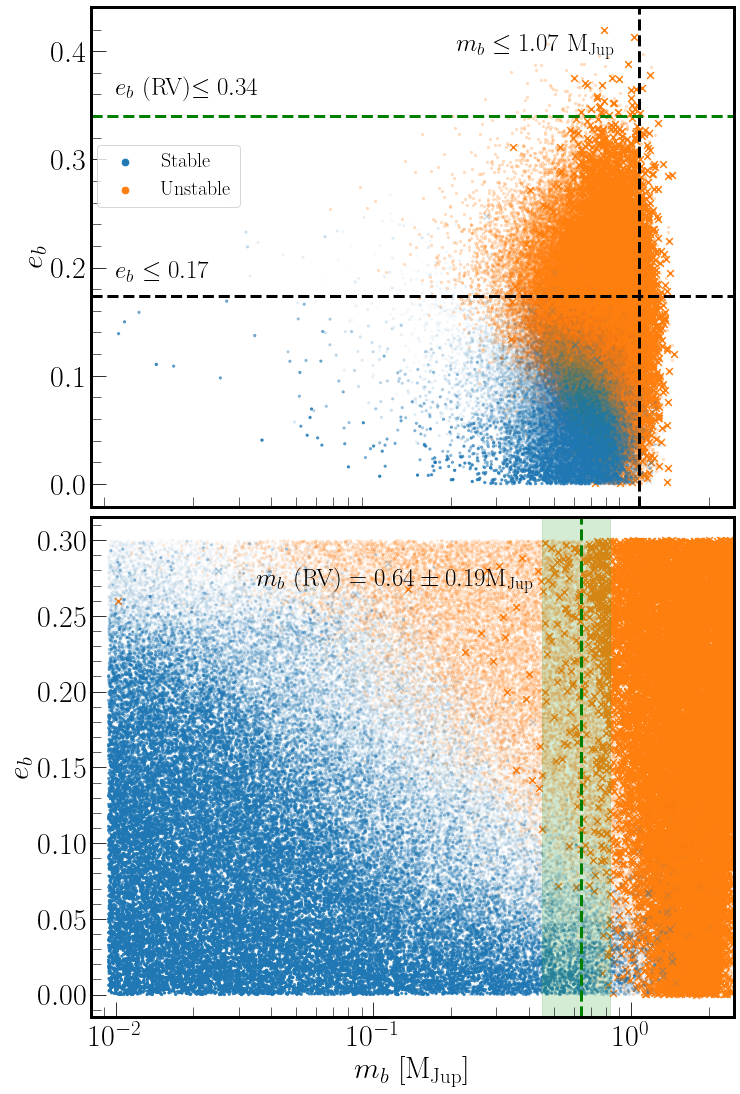

In [87]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30

# stable, in MMR
ax1.scatter(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            eb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            alpha=preds_rv[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mb_array[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            eb_array[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            alpha=preds_rv[preds_rv > 0.0][(np.array(deltaH_db)[preds_rv > 0.0] >= 0) \
                                           | np.isnan(deltaH_db)[preds_rv > 0.0]],
            c='C0',marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] < 0)],
            eb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] < 0)], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] >= 0)\
                                      | np.isnan(deltaH_db)[preds_rv == 0.0]],
            eb_array[preds_rv == 0.0][(np.array(deltaH_db)[preds_rv == 0.0] >= 0)\
                                     | np.isnan(deltaH_db)[preds_rv == 0.0]], 
            alpha=0.2,c='C1',s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
            eb_array_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][np.array(deltaH_db_logu)[spock_prob_logu > 0.0] < 0],
            c='C0',marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
            eb_array_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
      alpha=spock_prob_logu[spock_prob_logu > 0.0][(np.array(deltaH_db_logu)[spock_prob_logu > 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu > 0.0]],
            c='C0',marker='o',s=5,zorder=1)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu)[spock_prob_logu == 0.0] < 0],
            eb_array_logu[spock_prob_logu == 0.0][np.array(deltaH_db_logu)[spock_prob_logu == 0.0] < 0], 
            alpha=1.0,c='C1',marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mb_array_logu[spock_prob_logu == 0.0][(np.array(deltaH_db_logu)[spock_prob_logu == 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu == 0.0]],
            eb_array_logu[spock_prob_logu == 0.0][(np.array(deltaH_db_logu)[spock_prob_logu == 0.0] >= 0)\
                                                | np.isnan(deltaH_db_logu)[spock_prob_logu == 0.0]], 
            alpha=0.1,c='C1',s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='C2')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.21,0.40,r'$m_b \leq {}$'.format(1.07)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax1.text(0.01,0.19,r'$e_b$' + "~$\leq {}$".format(0.17),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

#plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

## Selecting all configurations in the 3:2 resonance for $c$ and $d$

In [46]:
logu_inres = np.array(logu_post)[np.array(deltaH_cd_logu) < 0.0] 
logu_outres = np.array(logu_post)[(np.array(deltaH_cd_logu) >= 0.0) | np.isnan(np.array(deltaH_cd_logu))]

In [47]:
print(np.shape(rv_inres),np.shape(logu_inres))

(21623, 6) (21604, 6)


In [48]:
mb_inres = (10**np.array([rv_inres[i][-2] for i in range(len(rv_inres))]))/9.54e-4
eb_inres = np.array([rv_inres[i][-1] for i in range(len(rv_inres))])

mb_inres_logu = (10**np.array([logu_inres[i][-2] for i in range(len(logu_inres))]))/9.54e-4
eb_inres_logu = np.array([logu_inres[i][-1] for i in range(len(logu_inres))])

In [55]:
# stability for 3:2 resonance
preds_inres_rv = preds_rv[np.array(deltaH_cd) < 0.0]
preds_inres_logu = preds_logu[np.array(deltaH_cd_logu) < 0.0]
print(len(preds_inres_rv) == len(mb_inres))
print(len(preds_inres_logu) == len(mb_inres_logu))

True
True


In [66]:
# rv configurations with both resonances
len(np.array(deltaH_db)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0)])

3246

In [70]:
# stable, inside 3:2 resonance and 2:1 resonance
len(np.array(mb_array)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0) & (preds_rv > 0.0)])

145

In [73]:
# unstable, inside 3:2 resonance and 2:1 resonance
len(np.array(mb_array)[(np.array(deltaH_cd) < 0.0) & (np.array(deltaH_db) < 0.0) & (preds_rv == 0.0)])

3101

In [67]:
# rv configurations inside the 3:2 resonance but outside the 2:1 resonance
len(np.array(deltaH_db)[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db))])

18377

In [77]:
# stable, MMR chain break
print(len(mb_array[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db)) &\
                      (preds_rv > 0.0)]))
# unstable, MMR chain break
print(len(mb_array[(np.array(deltaH_cd) < 0.0) & ((np.array(deltaH_db) >= 0.0) | np.isnan(deltaH_db)) &\
                      (preds_rv == 0.0)]))

4982
13395


In [76]:
len(mb_array[preds_rv > 0.0])

28170

In [80]:
def mmr_break(arr, cd_res, db_res, preds_arr, stable=True, chain=True):

    if stable:
        if chain: 
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr > 0.0)]
        else:
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr > 0.0)]
    else:
        if chain:
            res21 = arr[(np.array(cd_res) < 0.0) & (np.array(db_res) < 0.0) & (preds_arr == 0.0)]
        else:
            
            res21 = arr[(np.array(cd_res) < 0.0) & ((np.array(db_res) >= 0.0) | np.isnan(db_res)) &\
                        (preds_arr == 0.0)]
    return res21

In [120]:
preds_inmmr = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
preds_outmmr = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)

prob_inmmr = np.sum(preds_inmmr)/(np.sum(preds_outmmr) + np.sum(preds_outmmr))
print(prob_inmmr)

0.01119257


In [121]:
len(preds_outmmr) + len(preds_inmmr)

5127

In [122]:
len(preds_inmmr)

145

The above numbers show that there are:
* 145 stable configurations in the resonance change
* 4,982 stable configurations in the 3:2 MMR and outside the 2:1 MMR (resonance chain break)

These numbers don't add to the total number of stable configurations because I've only taken the subset of configurations inside the 3:2 MMR.

In [90]:
sigma=0.997
three_sigma_inres = [float(DescrStatsW(data=np.array(rv_inres)[:,i], 
                                    weights=spock_inres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_inres)[1])]
print((10**three_sigma_inres[-2])/9.54e-4, three_sigma_inres[-1])

1.0612165341243154 0.1780943934054289


In [161]:
sigma=0.997
three_sigma_outres = [float(DescrStatsW(data=np.array(rv_outres)[:,i], 
                                    weights=spock_outres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(rv_outres)[1])]
print((10**three_sigma_outres[-2])/9.54e-4, three_sigma_outres[-1])

1.0780534022731965 0.17249241058988674


<ipython-input-119-656c19225ff0>:97: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)


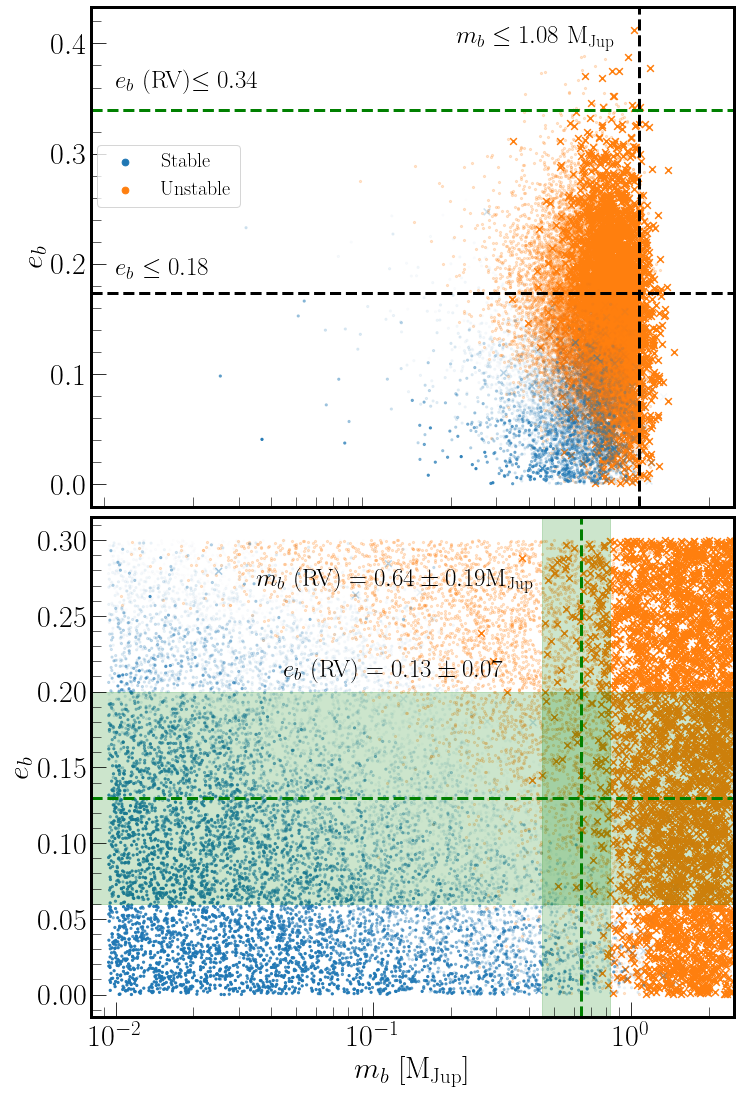

In [119]:
fig = plt.figure(1,figsize=(3*3.4, 6*3.4*3/4.))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30
c1 = 'C0'
c2 = 'C1'

# stable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            c=c1,marker='x',s=45,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            c=c1,marker='o',s=5,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True), 
            alpha=1.0,c=c2,marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False), 
            alpha=0.2,c=c2,s=5,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

##### log-uniform 

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
      alpha=mmr_break(preds_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=True),
            c=c1,marker='x',s=45,zorder=1, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
      alpha=mmr_break(preds_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=True,chain=False),
            c=c1,marker='o',s=5,zorder=1, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=True),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=True), 
            alpha=1.0,c=c2,marker='x',s=45,zorder=0, rasterized=True)

ax2.scatter(mmr_break(mb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=False),
            mmr_break(eb_array_logu, deltaH_cd_logu, deltaH_db_logu, preds_logu, stable=False,chain=False), 
            alpha=0.2,c=c2,s=5,marker='o',zorder=0, rasterized=True)

ax2.axvline(x=0.64, ls='--', color='g', lw=3)
ax2.axhline(y=0.13, ls='--', color='g', lw=3)
ax2.axvspan(0.64-0.19,0.64+0.19, alpha=0.2, color='g')
ax2.axhspan(0.13-0.07,0.13+0.07, alpha=0.2, color='g')

ax2.set_xlabel('$m_b$ [$\\rm{M}_{\\rm{Jup}}]$',fontsize=size,zorder=0)
ax2.set_ylabel('$e_b$',fontsize=size)
ax2.set_xscale('log')
ax2.minorticks_on()

ax1.set_xlim(8e-3, 2.5)
ax2.set_xlim(8e-3, 2.5)
ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.21,0.40,r'$m_b \leq {}$'.format(1.08)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
ax2.text(0.045,0.21,r'$e_b\ (\rm{RV}) = 0.13 \pm 0.07$',dict(size=25))
ax1.text(0.01,0.19,r'$e_b$' + "~$\leq {}$".format(0.18),dict(size=25))
ax1.text(0.01,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
plt.tight_layout()

plt.savefig('figures/Figure3.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

<ipython-input-224-c581b021c3f0>:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure3_singlepanel.pdf',dpi=300,bbox_inches='tight',padding=0)


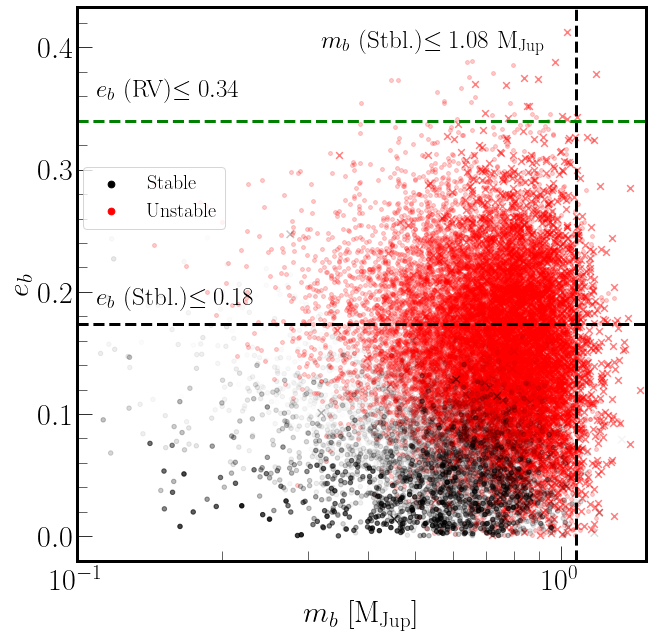

In [224]:
fig = plt.figure(1,figsize=(3*3.4, 4*3.4*3/4.))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(212)
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

size = 30
c1 = 'k'
c2 = 'r'

# stable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True),
            c=c1,marker='x',s=55,zorder=1, rasterized=True)

# stable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            alpha=mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False),
            c=c1,marker='o',s=20,zorder=1,label='Stable', rasterized=True)

# unstable, in MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True), 
            alpha=0.5,c=c2,marker='x',s=45,zorder=0, rasterized=True)

# unstable, out of MMR
ax1.scatter(mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False),
            mmr_break(eb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False), 
            alpha=0.2,c=c2,s=15,marker='o',zorder=0,label='Unstable', rasterized=True)

ax1.axvline(x=(10**three_sigma[-2])/9.54e-4, ls='--', color='k', lw=3)
#ax1.axvline(x=1.21, ls='--', color='g', lw=3)
ax1.axhline(y=three_sigma[-1], ls='--', color='k', lw=3)
ax1.axhline(y=0.34, ls='--', color='g', lw=3)

ax1.set_xlabel(r'$m_b$ [$\rm{M_{Jup}}$]',fontsize=size)
ax1.set_ylabel('$e_b$',fontsize=size)
ax1.set_xscale('log')
ax1.minorticks_on()

ax1.set_xlim(0.1, 1.5)
#ax2.set_xlim(8e-3, 2.5)
#ax1.set_xticks([])
#ax2.set_xticks([])
#ax2.set_yticks([])

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

#ax2.tick_params(axis='y', labelsize=30)
#ax2.tick_params(axis='x', labelsize=30)

leg1 = ax1.legend(prop={'size':20}, loc=(0.01, 0.6))
for lh in leg1.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [45]

    
ax1.text(0.32,0.40,r'$m_b$'+ "~(\\rm{Stbl.})"+"$\leq {}$".format(1.08)+' $\\rm{M}_{\\rm{Jup}}$',dict(size=25))
#ax2.text(0.035,0.27,r'$m_b\ (\rm{RV}) = 0.64 \pm 0.19$' + '$\\rm{M}_{\\rm{Jup}}$',dict(size=25))
#ax2.text(0.045,0.21,r'$e_b\ (\rm{RV}) = 0.13 \pm 0.07$',dict(size=25))
ax1.text(0.11,0.19,r'$e_b$' + "~(\\rm{Stbl.})"+"$\leq {}$".format(0.18),dict(size=25))
ax1.text(0.11,0.36,r'$e_b$' +"~(RV)" + '$\leq {}$'.format(0.34),dict(size=25))
#plt.tight_layout()

plt.savefig('figures/Figure3_singlepanel.pdf',dpi=300,bbox_inches='tight',padding=0)

plt.show()

In [154]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=True)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

55

In [156]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=True,chain=False)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

3409

In [150]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=True)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

1217

In [151]:
preds_rv_region = mmr_break(preds_rv, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)
mb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)
eb_rv_region = mmr_break(mb_array, deltaH_cd, deltaH_db, preds_rv, stable=False,chain=False)

rv_region = preds_rv_region[(mb_rv_region <= 0.64+0.19) & (mb_rv_region >= 0.64-0.19)]
len(rv_region)

9739

In [152]:
(55+3409)/(1217 + 9739)

0.31617378605330415

In [155]:
np.mean(rv_region)

0.1210724

In [157]:
np.mean(rv_region)

0.10788167